In [3]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from tqdm import tqdm
import warnings
import random

# Image Processing Libraries
from skimage import feature
from skimage.filters import gabor
from skimage.transform import resize
from skimage.morphology import disk
from skimage.filters.rank import entropy as entropy_filter
from skimage.measure import moments_hu
from PIL import Image

# Mathematical and Statistical Libraries
from scipy.stats import kurtosis, skew, ks_2samp, cramervonmises_2samp, anderson_ksamp, entropy
from scipy.spatial.distance import cdist, jensenshannon
from scipy.linalg import sqrtm
from sklearn.feature_selection import VarianceThreshold

# Persistent Homology
from gudhi import CubicalComplex

# Deep Learning Libraries
from keras.applications import InceptionV3, VGG16, ResNet50
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.models import Model

# Machine Learning Libraries
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Optimal Transport
import ot  # Optimal Transport Library



In [52]:
# Define the directory to save the results from feature extraction
# The `save_dir` is where the output files, such as CSVs containing extracted features, will be stored.
save_dir = '/Feature_Options'

# Ensure that the save directory exists. If it doesn't, create it.
# The `exist_ok=True` ensures that no error is raised if the directory already exists.
os.makedirs(save_dir, exist_ok=True)

# Define the dataset paths for the real and synthetic mammography datasets
# These paths point to the directories where the image data for each dataset is stored.
# The example below is for two datasets, but it can be adjusted to more than 2.
datasets = {
    #'InBreast': '/INbreast_images_center_cropped',
    'DDSM': '/DDSM_images_center_cropped',
    #'Mammo_medigan': '/medigan_images_center_cropped/'
    'HuggingFace': '/HF_synthetic_mammography_csaw_center_cropped'

}

# Explanation of Variables:
# - `save_dir`: The directory where all feature extraction outputs (e.g., CSV files) will be saved.
# - `datasets`: A dictionary containing dataset names as keys (e.g., 'DDSM', 'HuggingFace') and their corresponding directory paths as values.
#    - `DDSM`: Refers to a real mammography dataset containing equalized and center-cropped images.
#    - `HuggingFace`: Refers to a synthetic mammography dataset generated using HuggingFace tools, also containing center-cropped images.



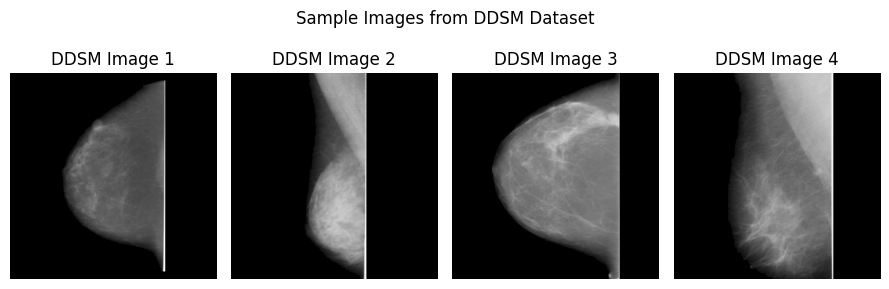

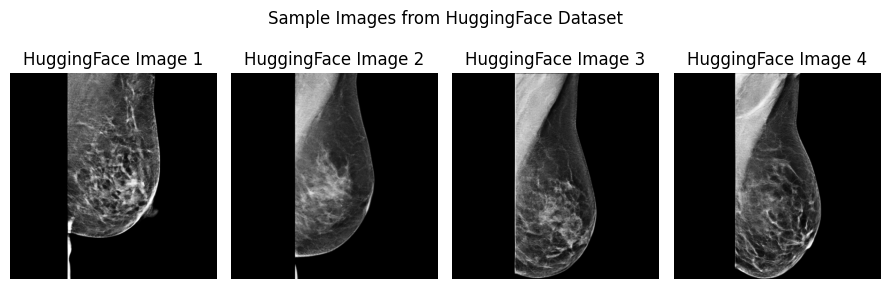

In [56]:
def display_sample_images(dataset_paths, num_images=5):
    """
    Display a random selection of images from the provided datasets.

    Parameters:
    - dataset_paths (dict): A dictionary with dataset names as keys and directory paths as values.
    - num_images (int): Number of images to display from each dataset.
    """
    for dataset_name, dataset_path in dataset_paths.items():
        # Get a list of all image files in the dataset directory
        image_files = [
            os.path.join(dataset_path, file)
            for file in os.listdir(dataset_path)
            if file.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        # Randomly select a subset of images
        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        # Display the selected images
        plt.figure(figsize=(9, 3))
        plt.suptitle(f"Sample Images from {dataset_name} Dataset", fontsize=12)
        for i, image_path in enumerate(selected_images, start=1):
            img = imread(image_path)
            plt.subplot(1, num_images, i)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.tight_layout()
            plt.title(f"{dataset_name} Image {i}",fontsize=12)
        plt.show()

# Call the function with the defined datasets and number of images to display
display_sample_images(datasets, num_images=4)


## Explanation of Feature Extraction Code

This section of the code handles feature extraction from images using both deep learning models and statistical/texture-based techniques. Here’s a breakdown of its key components:

### 1. Deep Learning Model Initialization

The `initialize_model` function is responsible for loading pre-trained deep learning models. These models are used to extract high-level features from images:

- **Supported models:** `InceptionV3`, `VGG16`, and `ResNet50`.
- The models are pre-trained on the ImageNet dataset, and their top layers are removed to focus on feature extraction using the global average pooling layer.
- Each model has its own preprocessing function to prepare input images for prediction.

### 2. Non-Deep Features

The `compute_non_deep_features` function extracts low-level features based on statistical, edge, and Fourier characteristics:

- **Statistical Features:** Mean, standard deviation, skewness, kurtosis, and median.
- **Edge Features:** Edge density and average intensity along detected edges.
- **Texture Features:** Fourier transform-based low and high-frequency energy.
- **Brightness and Contrast:** Captures basic intensity and range information.

### 3. Mammography-Specific Features

The `compute_mammography_features` function focuses on features relevant to digital mammography:

- Similar to `compute_non_deep_features` but includes:
  - **Gabor Features:** Extracts texture patterns using Gabor filters.
  - **Persistent Homology (Betti Numbers):** Captures topological information about the image.
  - **Hu Moments:** Captures spatial distribution and shape characteristics.
  - **Entropy:** Measures randomness in the image, useful for texture analysis.

### 4. Feature Extraction Workflow

The `extract_features` function integrates all feature extraction methods:

- Reads all images in the specified dataset directory and converts them to grayscale if needed.
- Resizes images to a standard size of `256x256` pixels.
- Depending on the specified feature type:
  - **Non-Deep Features:** Calls `compute_non_deep_features`.
  - **Mammography Features:** Calls `compute_mammography_features`.
  - **Deep Features:** Uses the initialized deep learning model to extract features.
- Limits the number of processed images using the `max_samples` parameter.

#### Workflow Overview:

1. Users specify the feature type (`Non-Deep`, `Mammography`, or a deep model like `Inception`).
2. The relevant model is initialized (if needed).
3. Features are extracted for each dataset and saved to a CSV file for further analysis.



In [57]:
# -----------------------
# Initialize Deep Learning Models
# -----------------------
def initialize_model(model_name):
    """
    Initialize a deep learning model for feature extraction.

    Parameters:
    - model_name (str): The name of the model to initialize. Options are 'Inception', 'VGG16', or 'ResNet'.

    Returns:
    - Model: A pre-trained model with global average pooling.
    - preprocess (function): Preprocessing function specific to the model.
    """
    if model_name == 'Inception':
        base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
        preprocess = inception_preprocess
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        preprocess = vgg_preprocess
    elif model_name == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
        preprocess = resnet_preprocess
    else:
        raise ValueError("Unsupported model name")
    return Model(inputs=base_model.input, outputs=base_model.output), preprocess

# -----------------------
# Compute Non-Deep Features
# -----------------------
def compute_non_deep_features(image_array):
    """
    Extract non-deep learning features from an image.

    Parameters:
    - image_array (np.ndarray): Grayscale image array.

    Returns:
    - list: Non-deep learning features.
    """
    # Standard preprocessing
    image = Image.fromarray(image_array).resize((256, 256))
    image_array = np.array(image)

    # Statistical features
    mean_val = np.mean(image_array)
    std_val = np.std(image_array)
    skewness = skew(image_array.flatten())
    kurt = kurtosis(image_array.flatten())
    median_val = np.median(image_array)

    # Edge and texture features
    edges = feature.canny(image_array)
    edge_density = np.sum(edges) / edges.size
    avg_edge_intensity = np.mean(image_array[edges]) if edges.any() else 0

    # Fourier transform features
    f_transform = np.fft.fft2(image_array)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    low_freq_energy = np.sum(magnitude_spectrum[:10, :10])
    high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:])

    # Contrast and brightness
    contrast = image_array.max() - image_array.min()
    brightness = np.mean(image_array)

    return [
        mean_val, std_val, skewness, kurt, median_val,
        edge_density, avg_edge_intensity, contrast, brightness,
        low_freq_energy, high_freq_energy
    ]

# -----------------------
# Compute Mammography-Specific Features
# -----------------------
def compute_mammography_features(image_array):
    """
    Extract mammography-specific features from an image.

    Parameters:
    - image_array (np.ndarray): Grayscale image array.

    Returns:
    - list: Mammography-specific features.
    """
    # Resize for consistency
    image = resize(image_array, (256, 256), mode='reflect', anti_aliasing=True)

    # Statistical features
    mean_val = np.mean(image)
    std_val = np.std(image)
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())

    # Texture and edge features
    edges = feature.canny(image)
    edge_density = np.sum(edges) / edges.size
    contrast = image.max() - image.min()

    # Fourier transform
    f_transform = np.fft.fft2(image)
    f_transform_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shift)
    low_freq_energy = np.sum(magnitude_spectrum[:10, :10])
    high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:])

    # Gabor features
    gabor_filtered, _ = gabor(image, frequency=0.6)
    gabor_mean = np.mean(gabor_filtered)
    gabor_std = np.std(gabor_filtered)

    # Persistent Homology
    cubical_complex = CubicalComplex(dimensions=image.shape, top_dimensional_cells=image.flatten())
    persistence = cubical_complex.persistence()
    betti_0 = sum(1 for _, dim in persistence if dim == 0)
    betti_1 = sum(1 for _, dim in persistence if dim == 1)

    # Moments and entropy
    hu_moments = moments_hu(image)
    local_entropy = entropy(image, disk(5)).mean()

    return [
        mean_val, std_val, skewness, kurt, edge_density, contrast,
        low_freq_energy, high_freq_energy, gabor_mean, gabor_std,
        betti_0, betti_1, *hu_moments, local_entropy
    ]

# -----------------------
# Extract Features
# -----------------------
def extract_features(dataset_path, feature_type, model=None, preprocess=None, max_samples=400):
    """
    Extract features from images in a dataset.

    Parameters:
    - dataset_path (str): Path to the dataset directory.
    - feature_type (str): Feature type ('Non-Deep', 'Mammography', 'Inception', etc.).
    - model (Model, optional): Pre-trained model for deep learning features.
    - preprocess (function, optional): Preprocessing function for the model.
    - max_samples (int): Maximum number of images to process.

    Returns:
    - np.ndarray: Extracted features.
    """
    features = []
    files = [
        os.path.join(dataset_path, filename)
        for filename in os.listdir(dataset_path)
        if filename.endswith(('.jpg', '.png', '.jpeg'))
    ]
    if max_samples and len(files) > max_samples:
        np.random.seed(42)
        files = np.random.choice(files, max_samples, replace=False)

    for filepath in tqdm(files, desc=f"Processing {dataset_path} ({feature_type})"):
        image = plt.imread(filepath)
        if image.ndim == 3:
            image = np.mean(image, axis=2)  # Convert to grayscale
        image = resize(image, (256, 256), mode='reflect', anti_aliasing=True)

        if feature_type == 'Non-Deep':
            features.append(compute_non_deep_features(image))
        elif feature_type == 'Mammography':
            features.append(compute_mammography_features(image))
        elif feature_type in ['Inception', 'VGG16', 'ResNet']:
            image_rgb = np.stack([image] * 3, axis=-1)
            processed_image = preprocess(np.expand_dims(image_rgb, axis=0))
            features.append(model.predict(processed_image).flatten())
        else:
            raise ValueError("Unsupported feature type")

    return np.array(features)



In [ ]:

# -----------------------
# Main Workflow
# -----------------------
feature_type = input("Choose feature type (Non-Deep, Mammography, Inception, VGG16, ResNet): ")

if feature_type in ['Inception', 'VGG16', 'ResNet']:
    model, preprocess = initialize_model(feature_type)
else:
    model, preprocess = None, None

for dataset_name, dataset_path in datasets.items():
    print(f"Extracting features for {dataset_name} using {feature_type}...")
    features = extract_features(dataset_path, feature_type, model=model, preprocess=preprocess, max_samples=400)
    pd.DataFrame(features).to_csv(os.path.join(save_dir, f"{dataset_name}_{feature_type}_features.csv"), index=False)
    print(f"Features shape for {dataset_name}: {features.shape}")

In [59]:
def compute_mammography_features(image_array):
    """Extract mammography-specific features from an image."""
    try:
        # Resize to standard size
        image = resize(image_array, (256, 256), mode='reflect', anti_aliasing=True)

        # Ensure the image is 2D
        if image.ndim != 2:
            raise ValueError("Input image must be grayscale (2D array).")

        # Check for constant image values
        if np.all(image == image[0, 0]):
            raise ValueError("Image has no variation (constant values).")

        # Statistical features
        mean_val = np.mean(image)
        std_val = np.std(image)
        skewness = stats.skew(image.flatten())
        kurt = stats.kurtosis(image.flatten())

        # Texture and edge features
        edges = feature.canny(image)
        edge_density = np.sum(edges) / edges.size
        contrast = image.max() - image.min()

        # Fourier transform
        f_transform = np.fft.fft2(image)
        f_transform_shift = np.fft.fftshift(f_transform)
        magnitude_spectrum = np.abs(f_transform_shift)
        low_freq_energy = np.sum(magnitude_spectrum[:10, :10])
        high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:])

        # Gabor features
        gabor_filtered, _ = gabor(image, frequency=0.6)
        gabor_mean = np.mean(gabor_filtered)
        gabor_std = np.std(gabor_filtered)

        # Persistent Homology
        cubical_complex = CubicalComplex(dimensions=image.shape, top_dimensional_cells=image.flatten())
        persistence = cubical_complex.persistence()
        betti_0 = sum(1 for _, dim in persistence if dim == 0)
        betti_1 = sum(1 for _, dim in persistence if dim == 1)

        # Moments and entropy
        hu_moments = moments_hu(image)
        local_entropy = entropy_filter(image, disk(5)).mean() if image.any() else 0

        features = [
            mean_val, std_val, skewness, kurt, edge_density, contrast,
            low_freq_energy, high_freq_energy, gabor_mean, gabor_std, betti_0, betti_1,
            *hu_moments, local_entropy
        ]
        return features

    except Exception as e:
        print(f"Error processing image: {e}")
        return [np.nan] * 15  # Return NaNs if there's an error


In [83]:
# -------------------------------
# Feature Extraction and Selection
# -------------------------------

# Process user input for feature types
"""
This section handles the user input for feature types and initializes the appropriate models
for deep learning-based feature extraction if selected.

Feature Types:
- Non-Deep: Extracts non-deep statistical and texture-based features.
- Mammography: Extracts features specific to digital mammography.
- Inception, VGG16, ResNet: Uses pre-trained deep learning models for feature extraction.
"""
feature_types = input("Choose feature types (e.g., Non-Deep,Mammography,Inception): ")
feature_types = [ft.strip() for ft in feature_types.split(',')]

# Initialize models and preprocessors for deep learning feature types
models_preprocessors = {}
for ft in feature_types:
    if ft in ['Inception', 'VGG16', 'ResNet']:
        model, preprocess = initialize_model(ft)
        models_preprocessors[ft] = (model, preprocess)

# Dictionary to store extracted features for all datasets
all_features = {}

# Extract features for each dataset
"""
This section loops through all datasets to extract features based on the selected feature types.
The progress of feature extraction is shown as a single progress bar for each dataset.
"""
for dataset_name, dataset_path in datasets.items():
    print(f"\nExtracting features for {dataset_name} using {feature_types}...")

    # Retrieve file paths for all images in the dataset
    files = [
        os.path.join(dataset_path, filename)
        for filename in os.listdir(dataset_path)
        if filename.endswith(('.jpg', '.png', '.jpeg'))
    ]
    dataset_features = []

    # Single progress bar for the entire dataset
    with tqdm(total=len(files), desc=f"Processing {dataset_name}") as pbar:
        for filepath in files:
            image = plt.imread(filepath)
            if image.ndim == 3:
                image = np.mean(image, axis=2)  # Convert to grayscale
            image = resize(image, (256, 256), mode='reflect', anti_aliasing=True)

            # Extract features based on the selected types
            feature_set = []
            if 'Non-Deep' in feature_types:
                feature_set.extend(compute_non_deep_features(image))
            if 'Mammography' in feature_types:
                feature_set.extend(compute_mammography_features(image))
            for deep_type, (model, preprocess) in models_preprocessors.items():
                image_rgb = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB
                processed_image = preprocess(np.expand_dims(image_rgb, axis=0))
                feature_set.extend(model.predict(processed_image).flatten())

            dataset_features.append(feature_set)
            pbar.update(1)

    # Save extracted features
    dataset_features = np.array(dataset_features)
    all_features[dataset_name] = dataset_features
    file_name = f"{dataset_name}_{'_'.join(feature_types).replace(' ', '')}_features.csv"
    file_path = os.path.join(save_dir, file_name)
    pd.DataFrame(dataset_features).to_csv(file_path, index=False)
    print(f"Features for {dataset_name} saved to: {file_path}")

# Ask the user if they want to perform feature selection
"""
Feature Selection:
This section allows the user to perform feature selection based on variance. The top-k features
with the highest variance are selected, and the selected features are saved for further computation.
"""
perform_feature_selection = input("\nDo you want to perform feature selection on the extracted features? (yes/no): ").strip().lower()

if perform_feature_selection == 'yes':
    def select_top_features(features, top_k=10):
        """
        Select the top features based on variance.

        Parameters:
        - features (np.ndarray): The extracted feature matrix.
        - top_k (int): The number of top features to select.

        Returns:
        - np.ndarray: Matrix with only the top-k selected features.
        - np.ndarray: Indices of the selected features.
        """
        feature_variances = np.var(features, axis=0)
        top_feature_indices = np.argsort(feature_variances)[-top_k:]
        return features[:, top_feature_indices], top_feature_indices

    # Ask the user for the number of top features to select
    top_k = int(input("Enter the number of top features to select (e.g., 10): "))

    for dataset_name, dataset_features in all_features.items():
        # Perform feature selection
        selected_features, selected_indices = select_top_features(dataset_features, top_k=top_k)
        all_features[dataset_name] = selected_features

        # Save selected features
        selected_file_name = f"{dataset_name}_{'_'.join(feature_types).replace(' ', '')}_Top{top_k}_features.csv"
        selected_file_path = os.path.join(save_dir, selected_file_name)
        pd.DataFrame(selected_features).to_csv(selected_file_path, index=False)
        print(f"Selected features for {dataset_name} saved to: {selected_file_path}")

    print(f"\nFeature selection completed. Top {top_k} features have been saved and are ready for computation.")
else:
    print("\nFeature selection skipped. Using all extracted features for computation.")


Choose feature types (e.g., Non-Deep,Mammography,Inception): Inception

Extracting features for DDSM using ['Inception']...


Processing DDSM:   0%|          | 0/975 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Processing DDSM:   0%|          | 1/975 [00:06<1:39:56,  6.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   0%|          | 3/975 [00:06<26:52,  1.66s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   1%|          | 5/975 [00:06<13:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   1%|          | 7/975 [00:06<08:27,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   1%|          | 9/975 [00:06<05:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   1%|          | 11/975 [00:11<17:03,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:   1%|▏         | 13/975 [00:11<11:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:   2%|▏         | 15/975 [00:11<08:24,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   2%|▏         | 17/975 [00:12<06:09,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   2%|▏         | 19/975 [00:12<04:38,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   2%|▏         | 21/975 [00:12<03:36,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   2%|▏         | 23/975 [00:12<02:54,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   3%|▎         | 25/975 [00:12<02:25,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   3%|▎         | 27/975 [00:12<02:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   3%|▎         | 29/975 [00:13<01:50,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   3%|▎         | 31/975 [00:13<01:39,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   3%|▎         | 33/975 [00:13<01:32, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   4%|▎         | 35/975 [00:13<01:28, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   4%|▍         | 37/975 [00:13<01:24, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   4%|▍         | 39/975 [00:13<01:22, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   4%|▍         | 41/975 [00:14<01:20, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   4%|▍         | 43/975 [00:14<01:18, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   5%|▍         | 45/975 [00:14<01:18, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   5%|▍         | 47/975 [00:14<01:18, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:   5%|▌         | 49/975 [00:14<01:18, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   5%|▌         | 51/975 [00:14<01:17, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   5%|▌         | 53/975 [00:15<01:16, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   6%|▌         | 55/975 [00:15<01:16, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   6%|▌         | 57/975 [00:15<01:15, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   6%|▌         | 59/975 [00:15<01:15, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:   6%|▋         | 61/975 [00:15<01:16, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:   6%|▋         | 63/975 [00:15<01:16, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   7%|▋         | 65/975 [00:16<01:15, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   7%|▋         | 67/975 [00:16<01:15, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   7%|▋         | 69/975 [00:16<01:15, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   7%|▋         | 71/975 [00:16<01:14, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:   7%|▋         | 73/975 [00:16<01:15, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   8%|▊         | 75/975 [00:16<01:15, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   8%|▊         | 77/975 [00:17<01:15, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   8%|▊         | 79/975 [00:17<01:14, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:   8%|▊         | 81/975 [00:17<01:13, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   9%|▊         | 83/975 [00:17<01:13, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:   9%|▊         | 85/975 [00:17<01:13, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   9%|▉         | 87/975 [00:17<01:14, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:   9%|▉         | 89/975 [00:18<01:12, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:   9%|▉         | 91/975 [00:18<01:12, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  10%|▉         | 93/975 [00:18<01:12, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  10%|▉         | 95/975 [00:18<01:13, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  10%|▉         | 97/975 [00:18<01:12, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  10%|█         | 99/975 [00:18<01:12, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  10%|█         | 101/975 [00:19<01:12, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  11%|█         | 103/975 [00:19<01:11, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  11%|█         | 105/975 [00:19<01:11, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  11%|█         | 107/975 [00:19<01:10, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  11%|█         | 109/975 [00:19<01:10, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  11%|█▏        | 111/975 [00:19<01:11, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  12%|█▏        | 113/975 [00:19<01:10, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  12%|█▏        | 115/975 [00:20<01:10, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  12%|█▏        | 117/975 [00:20<01:11, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  12%|█▏        | 119/975 [00:20<01:12, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  12%|█▏        | 121/975 [00:20<01:12, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  13%|█▎        | 123/975 [00:20<01:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  13%|█▎        | 125/975 [00:21<01:12, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  13%|█▎        | 127/975 [00:21<01:11, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  13%|█▎        | 129/975 [00:21<01:11, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  13%|█▎        | 131/975 [00:21<01:10, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  14%|█▎        | 133/975 [00:21<01:11, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  14%|█▍        | 135/975 [00:21<01:10, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  14%|█▍        | 137/975 [00:22<01:10, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  14%|█▍        | 139/975 [00:22<01:11, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  14%|█▍        | 141/975 [00:22<01:11, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  15%|█▍        | 143/975 [00:22<01:11, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  15%|█▍        | 145/975 [00:22<01:11, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  15%|█▌        | 147/975 [00:22<01:11, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  15%|█▌        | 149/975 [00:23<01:10, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  15%|█▌        | 151/975 [00:23<01:09, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  16%|█▌        | 153/975 [00:23<01:08, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  16%|█▌        | 155/975 [00:23<01:08, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  16%|█▌        | 157/975 [00:23<01:08, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  16%|█▋        | 159/975 [00:23<01:08, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  17%|█▋        | 161/975 [00:24<01:08, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  17%|█▋        | 163/975 [00:24<01:08, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  17%|█▋        | 165/975 [00:24<01:08, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  17%|█▋        | 167/975 [00:24<01:07, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  17%|█▋        | 169/975 [00:24<01:09, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  18%|█▊        | 171/975 [00:24<01:08, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  18%|█▊        | 173/975 [00:25<01:07, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  18%|█▊        | 175/975 [00:25<01:06, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  18%|█▊        | 177/975 [00:25<01:05, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  18%|█▊        | 179/975 [00:25<01:05, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  19%|█▊        | 181/975 [00:25<01:05, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  19%|█▉        | 183/975 [00:25<01:05, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  19%|█▉        | 185/975 [00:26<01:05, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  19%|█▉        | 187/975 [00:26<01:05, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  19%|█▉        | 189/975 [00:26<01:06, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  20%|█▉        | 191/975 [00:26<01:06, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  20%|█▉        | 193/975 [00:26<01:07, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  20%|██        | 195/975 [00:26<01:06, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  20%|██        | 197/975 [00:27<01:05, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing DDSM:  20%|██        | 199/975 [00:27<01:04, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  21%|██        | 201/975 [00:27<01:04, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  21%|██        | 203/975 [00:27<01:04, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  21%|██        | 205/975 [00:27<01:04, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  21%|██        | 207/975 [00:27<01:03, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  21%|██▏       | 209/975 [00:28<01:03, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  22%|██▏       | 211/975 [00:28<01:03, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  22%|██▏       | 213/975 [00:28<01:03, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  22%|██▏       | 215/975 [00:28<01:03, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  22%|██▏       | 217/975 [00:28<01:03, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  22%|██▏       | 219/975 [00:28<01:03, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  23%|██▎       | 221/975 [00:29<01:03, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  23%|██▎       | 223/975 [00:29<01:02, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  23%|██▎       | 225/975 [00:29<01:02, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  23%|██▎       | 227/975 [00:29<01:02, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  23%|██▎       | 229/975 [00:29<01:03, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  24%|██▎       | 231/975 [00:29<01:03, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  24%|██▍       | 233/975 [00:30<01:02, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  24%|██▍       | 235/975 [00:30<01:02, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  24%|██▍       | 237/975 [00:30<01:01, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  25%|██▍       | 239/975 [00:30<01:02, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  25%|██▍       | 241/975 [00:30<01:02, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  25%|██▍       | 243/975 [00:30<01:02, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  25%|██▌       | 245/975 [00:31<01:01, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  25%|██▌       | 247/975 [00:31<01:01, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  26%|██▌       | 249/975 [00:31<01:00, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  26%|██▌       | 251/975 [00:31<01:01, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  26%|██▌       | 253/975 [00:31<01:02, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  26%|██▌       | 255/975 [00:31<01:01, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  26%|██▋       | 257/975 [00:32<01:00, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  27%|██▋       | 259/975 [00:32<00:59, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  27%|██▋       | 261/975 [00:32<01:00, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  27%|██▋       | 263/975 [00:32<01:00, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  27%|██▋       | 265/975 [00:32<00:59, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  27%|██▋       | 267/975 [00:32<01:00, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  28%|██▊       | 269/975 [00:33<01:01, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  28%|██▊       | 271/975 [00:33<01:00, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  28%|██▊       | 273/975 [00:33<00:59, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  28%|██▊       | 275/975 [00:33<00:59, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  28%|██▊       | 277/975 [00:33<01:01, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  29%|██▊       | 279/975 [00:34<01:00, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  29%|██▉       | 281/975 [00:34<00:59, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  29%|██▉       | 283/975 [00:34<00:58, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  29%|██▉       | 285/975 [00:34<00:58, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  29%|██▉       | 287/975 [00:34<00:58, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  30%|██▉       | 289/975 [00:34<01:00, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  30%|██▉       | 291/975 [00:35<00:59, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  30%|███       | 293/975 [00:35<00:59, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  30%|███       | 295/975 [00:35<00:59, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  30%|███       | 297/975 [00:35<00:58, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  31%|███       | 299/975 [00:35<00:59, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  31%|███       | 301/975 [00:35<00:59, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  31%|███       | 303/975 [00:36<00:59, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  31%|███▏      | 305/975 [00:36<00:59, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  31%|███▏      | 307/975 [00:36<00:58, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  32%|███▏      | 309/975 [00:36<00:57, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  32%|███▏      | 311/975 [00:36<00:57, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  32%|███▏      | 313/975 [00:36<00:57, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  32%|███▏      | 315/975 [00:37<00:56, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  33%|███▎      | 317/975 [00:37<00:56, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  33%|███▎      | 319/975 [00:37<00:55, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  33%|███▎      | 321/975 [00:37<00:54, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  33%|███▎      | 323/975 [00:37<00:56, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  33%|███▎      | 325/975 [00:38<00:55, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  34%|███▎      | 327/975 [00:38<00:55, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  34%|███▎      | 329/975 [00:38<00:54, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  34%|███▍      | 331/975 [00:38<00:54, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  34%|███▍      | 333/975 [00:38<00:55, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  34%|███▍      | 335/975 [00:38<00:55, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  35%|███▍      | 337/975 [00:39<00:55, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  35%|███▍      | 339/975 [00:39<00:55, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  35%|███▍      | 341/975 [00:39<00:54, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  35%|███▌      | 343/975 [00:39<00:54, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  35%|███▌      | 345/975 [00:39<00:54, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  36%|███▌      | 347/975 [00:39<00:54, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  36%|███▌      | 349/975 [00:40<00:53, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  36%|███▌      | 351/975 [00:40<00:53, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  36%|███▌      | 353/975 [00:40<00:53, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  36%|███▋      | 355/975 [00:40<00:52, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  37%|███▋      | 357/975 [00:40<00:53, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  37%|███▋      | 359/975 [00:40<00:52, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  37%|███▋      | 361/975 [00:41<00:52, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  37%|███▋      | 363/975 [00:41<00:51, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  37%|███▋      | 365/975 [00:41<00:51, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  38%|███▊      | 367/975 [00:41<00:50, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  38%|███▊      | 369/975 [00:41<00:50, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  38%|███▊      | 371/975 [00:41<00:50, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  38%|███▊      | 373/975 [00:42<00:50, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  38%|███▊      | 375/975 [00:42<00:49, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  39%|███▊      | 377/975 [00:42<00:49, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  39%|███▉      | 379/975 [00:42<00:49, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  39%|███▉      | 381/975 [00:42<00:49, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  39%|███▉      | 383/975 [00:42<00:50, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  39%|███▉      | 385/975 [00:43<00:49, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  40%|███▉      | 387/975 [00:43<00:49, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  40%|███▉      | 389/975 [00:43<00:49, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  40%|████      | 391/975 [00:43<00:48, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  40%|████      | 393/975 [00:43<00:48, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  41%|████      | 395/975 [00:43<00:48, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  41%|████      | 397/975 [00:44<00:48, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  41%|████      | 399/975 [00:44<00:47, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  41%|████      | 401/975 [00:44<00:47, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  41%|████▏     | 403/975 [00:44<00:47, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  42%|████▏     | 405/975 [00:44<00:48, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  42%|████▏     | 407/975 [00:44<00:47, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  42%|████▏     | 409/975 [00:45<00:47, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  42%|████▏     | 411/975 [00:45<00:47, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  42%|████▏     | 413/975 [00:45<00:47, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  43%|████▎     | 415/975 [00:45<00:47, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  43%|████▎     | 417/975 [00:45<00:47, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  43%|████▎     | 419/975 [00:45<00:47, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  43%|████▎     | 421/975 [00:46<00:48, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  43%|████▎     | 423/975 [00:46<00:48, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  44%|████▎     | 425/975 [00:46<00:48, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  44%|████▍     | 427/975 [00:46<00:48, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  44%|████▍     | 429/975 [00:46<00:48, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  44%|████▍     | 431/975 [00:47<00:47, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  44%|████▍     | 433/975 [00:47<00:47, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  45%|████▍     | 435/975 [00:47<00:47, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  45%|████▍     | 437/975 [00:47<00:47, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  45%|████▌     | 439/975 [00:47<00:49, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  45%|████▌     | 441/975 [00:47<00:48, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  45%|████▌     | 443/975 [00:48<00:47, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  46%|████▌     | 445/975 [00:48<00:46, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  46%|████▌     | 447/975 [00:48<00:46, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  46%|████▌     | 449/975 [00:48<00:45, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  46%|████▋     | 451/975 [00:48<00:45, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  46%|████▋     | 453/975 [00:48<00:45, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  47%|████▋     | 455/975 [00:49<00:44, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  47%|████▋     | 457/975 [00:49<00:44, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  47%|████▋     | 459/975 [00:49<00:43, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  47%|████▋     | 461/975 [00:49<00:43, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  47%|████▋     | 463/975 [00:49<00:43, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  48%|████▊     | 465/975 [00:49<00:42, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  48%|████▊     | 467/975 [00:50<00:42, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  48%|████▊     | 469/975 [00:50<00:42, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  48%|████▊     | 471/975 [00:50<00:42, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  49%|████▊     | 473/975 [00:50<00:43, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  49%|████▊     | 475/975 [00:50<00:43, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  49%|████▉     | 477/975 [00:51<00:42, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  49%|████▉     | 479/975 [00:51<00:42, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  49%|████▉     | 481/975 [00:51<00:42, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  50%|████▉     | 483/975 [00:51<00:42, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing DDSM:  50%|████▉     | 485/975 [00:51<00:43, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  50%|████▉     | 487/975 [00:51<00:42, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  50%|█████     | 489/975 [00:52<00:41, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  50%|█████     | 491/975 [00:52<00:41, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  51%|█████     | 493/975 [00:52<00:40, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  51%|█████     | 495/975 [00:52<00:40, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  51%|█████     | 497/975 [00:52<00:40, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  51%|█████     | 499/975 [00:52<00:39, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  51%|█████▏    | 501/975 [00:53<00:39, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  52%|█████▏    | 503/975 [00:53<00:39, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  52%|█████▏    | 505/975 [00:53<00:38, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  52%|█████▏    | 507/975 [00:53<00:41, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  52%|█████▏    | 509/975 [00:53<00:41, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  52%|█████▏    | 511/975 [00:53<00:40, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  53%|█████▎    | 513/975 [00:54<00:39, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  53%|█████▎    | 515/975 [00:54<00:38, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  53%|█████▎    | 517/975 [00:54<00:38, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  53%|█████▎    | 519/975 [00:54<00:38, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  53%|█████▎    | 521/975 [00:54<00:38, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  54%|█████▎    | 523/975 [00:54<00:38, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  54%|█████▍    | 525/975 [00:55<00:38, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  54%|█████▍    | 527/975 [00:55<00:37, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  54%|█████▍    | 529/975 [00:55<00:37, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  54%|█████▍    | 531/975 [00:55<00:37, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  55%|█████▍    | 533/975 [00:55<00:37, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  55%|█████▍    | 535/975 [00:55<00:37, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  55%|█████▌    | 537/975 [00:56<00:36, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  55%|█████▌    | 539/975 [00:56<00:36, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  55%|█████▌    | 541/975 [00:56<00:36, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  56%|█████▌    | 543/975 [00:56<00:36, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  56%|█████▌    | 545/975 [00:56<00:37, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  56%|█████▌    | 547/975 [00:56<00:36, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  56%|█████▋    | 549/975 [00:57<00:36, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  57%|█████▋    | 551/975 [00:57<00:35, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  57%|█████▋    | 553/975 [00:57<00:35, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  57%|█████▋    | 555/975 [00:57<00:35, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  57%|█████▋    | 557/975 [00:57<00:35, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  57%|█████▋    | 559/975 [00:57<00:35, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  58%|█████▊    | 561/975 [00:58<00:35, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  58%|█████▊    | 563/975 [00:58<00:35, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  58%|█████▊    | 565/975 [00:58<00:35, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  58%|█████▊    | 567/975 [00:58<00:35, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  58%|█████▊    | 569/975 [00:58<00:35, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  59%|█████▊    | 571/975 [00:59<00:35, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  59%|█████▉    | 573/975 [00:59<00:34, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  59%|█████▉    | 575/975 [00:59<00:34, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  59%|█████▉    | 577/975 [00:59<00:34, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  59%|█████▉    | 579/975 [00:59<00:34, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  60%|█████▉    | 581/975 [00:59<00:34, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  60%|█████▉    | 583/975 [01:00<00:34, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  60%|██████    | 585/975 [01:00<00:35, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  60%|██████    | 587/975 [01:00<00:35, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  60%|██████    | 589/975 [01:00<00:34, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  61%|██████    | 591/975 [01:00<00:34, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  61%|██████    | 593/975 [01:01<00:33, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  61%|██████    | 595/975 [01:01<00:33, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  61%|██████    | 597/975 [01:01<00:32, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  61%|██████▏   | 599/975 [01:01<00:32, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  62%|██████▏   | 601/975 [01:01<00:32, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  62%|██████▏   | 603/975 [01:01<00:32, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  62%|██████▏   | 605/975 [01:02<00:32, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  62%|██████▏   | 607/975 [01:02<00:31, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  62%|██████▏   | 609/975 [01:02<00:31, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  63%|██████▎   | 611/975 [01:02<00:31, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  63%|██████▎   | 613/975 [01:02<00:32, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  63%|██████▎   | 615/975 [01:02<00:32, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  63%|██████▎   | 617/975 [01:03<00:31, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  63%|██████▎   | 619/975 [01:03<00:31, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  64%|██████▎   | 621/975 [01:03<00:30, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  64%|██████▍   | 623/975 [01:03<00:30, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  64%|██████▍   | 625/975 [01:03<00:30, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  64%|██████▍   | 627/975 [01:03<00:30, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  65%|██████▍   | 629/975 [01:04<00:29, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  65%|██████▍   | 631/975 [01:04<00:29, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  65%|██████▍   | 633/975 [01:04<00:28, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  65%|██████▌   | 635/975 [01:04<00:28, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  65%|██████▌   | 637/975 [01:04<00:28, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  66%|██████▌   | 639/975 [01:04<00:28, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  66%|██████▌   | 641/975 [01:05<00:28, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  66%|██████▌   | 643/975 [01:05<00:27, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  66%|██████▌   | 645/975 [01:05<00:27, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  66%|██████▋   | 647/975 [01:05<00:27, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  67%|██████▋   | 649/975 [01:05<00:27, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  67%|██████▋   | 651/975 [01:05<00:27, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  67%|██████▋   | 653/975 [01:06<00:26, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  67%|██████▋   | 655/975 [01:06<00:26, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing DDSM:  67%|██████▋   | 657/975 [01:06<00:26, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  68%|██████▊   | 659/975 [01:06<00:26, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  68%|██████▊   | 661/975 [01:06<00:26, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  68%|██████▊   | 663/975 [01:06<00:25, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  68%|██████▊   | 665/975 [01:07<00:25, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  68%|██████▊   | 667/975 [01:07<00:25, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  69%|██████▊   | 669/975 [01:07<00:25, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  69%|██████▉   | 671/975 [01:07<00:25, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  69%|██████▉   | 673/975 [01:07<00:25, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  69%|██████▉   | 675/975 [01:07<00:24, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  69%|██████▉   | 677/975 [01:08<00:24, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  70%|██████▉   | 679/975 [01:08<00:23, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  70%|██████▉   | 681/975 [01:08<00:23, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  70%|███████   | 683/975 [01:08<00:24, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  70%|███████   | 685/975 [01:08<00:24, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  70%|███████   | 687/975 [01:08<00:24, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  71%|███████   | 689/975 [01:09<00:24, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  71%|███████   | 691/975 [01:09<00:23, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  71%|███████   | 693/975 [01:09<00:23, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  71%|███████▏  | 695/975 [01:09<00:23, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  71%|███████▏  | 697/975 [01:09<00:24, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  72%|███████▏  | 699/975 [01:09<00:23, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  72%|███████▏  | 701/975 [01:10<00:23, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  72%|███████▏  | 703/975 [01:10<00:23, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  72%|███████▏  | 705/975 [01:10<00:22, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  73%|███████▎  | 707/975 [01:10<00:23, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  73%|███████▎  | 709/975 [01:10<00:23, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  73%|███████▎  | 711/975 [01:10<00:22, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  73%|███████▎  | 713/975 [01:11<00:22, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  73%|███████▎  | 715/975 [01:11<00:22, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  74%|███████▎  | 717/975 [01:11<00:21, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  74%|███████▎  | 719/975 [01:11<00:21, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  74%|███████▍  | 721/975 [01:11<00:21, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  74%|███████▍  | 723/975 [01:12<00:23, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  74%|███████▍  | 725/975 [01:12<00:22, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  75%|███████▍  | 727/975 [01:12<00:21, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  75%|███████▍  | 729/975 [01:12<00:21, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  75%|███████▍  | 731/975 [01:12<00:21, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  75%|███████▌  | 733/975 [01:12<00:20, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  75%|███████▌  | 735/975 [01:13<00:20, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  76%|███████▌  | 737/975 [01:13<00:20, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  76%|███████▌  | 739/975 [01:13<00:19, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  76%|███████▌  | 741/975 [01:13<00:19, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  76%|███████▌  | 743/975 [01:13<00:19, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  76%|███████▋  | 745/975 [01:13<00:19, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  77%|███████▋  | 747/975 [01:14<00:19, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  77%|███████▋  | 749/975 [01:14<00:19, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  77%|███████▋  | 751/975 [01:14<00:18, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  77%|███████▋  | 753/975 [01:14<00:18, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  77%|███████▋  | 755/975 [01:14<00:18, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  78%|███████▊  | 757/975 [01:14<00:18, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  78%|███████▊  | 759/975 [01:15<00:18, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  78%|███████▊  | 761/975 [01:15<00:18, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  78%|███████▊  | 763/975 [01:15<00:18, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  78%|███████▊  | 765/975 [01:15<00:17, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  79%|███████▊  | 767/975 [01:15<00:17, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  79%|███████▉  | 769/975 [01:15<00:17, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  79%|███████▉  | 771/975 [01:16<00:17, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  79%|███████▉  | 773/975 [01:16<00:17, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  79%|███████▉  | 775/975 [01:16<00:16, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  80%|███████▉  | 777/975 [01:16<00:16, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  80%|███████▉  | 779/975 [01:16<00:16, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  80%|████████  | 781/975 [01:16<00:16, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  80%|████████  | 783/975 [01:17<00:16, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  81%|████████  | 785/975 [01:17<00:15, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  81%|████████  | 787/975 [01:17<00:15, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  81%|████████  | 789/975 [01:17<00:15, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  81%|████████  | 791/975 [01:17<00:15, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  81%|████████▏ | 793/975 [01:17<00:15, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  82%|████████▏ | 795/975 [01:18<00:15, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  82%|████████▏ | 797/975 [01:18<00:14, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  82%|████████▏ | 799/975 [01:18<00:14, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  82%|████████▏ | 801/975 [01:18<00:14, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  82%|████████▏ | 803/975 [01:18<00:14, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  83%|████████▎ | 805/975 [01:18<00:14, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  83%|████████▎ | 807/975 [01:19<00:13, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  83%|████████▎ | 809/975 [01:19<00:13, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  83%|████████▎ | 811/975 [01:19<00:13, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  83%|████████▎ | 813/975 [01:19<00:13, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  84%|████████▎ | 815/975 [01:19<00:13, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  84%|████████▍ | 817/975 [01:19<00:13, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  84%|████████▍ | 819/975 [01:20<00:12, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  84%|████████▍ | 821/975 [01:20<00:12, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  84%|████████▍ | 823/975 [01:20<00:12, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  85%|████████▍ | 825/975 [01:20<00:12, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  85%|████████▍ | 827/975 [01:20<00:12, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  85%|████████▌ | 829/975 [01:20<00:12, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  85%|████████▌ | 831/975 [01:21<00:12, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  85%|████████▌ | 833/975 [01:21<00:11, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  86%|████████▌ | 835/975 [01:21<00:11, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  86%|████████▌ | 837/975 [01:21<00:11, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  86%|████████▌ | 839/975 [01:21<00:11, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing DDSM:  86%|████████▋ | 841/975 [01:21<00:11, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  86%|████████▋ | 843/975 [01:22<00:11, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  87%|████████▋ | 845/975 [01:22<00:10, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing DDSM:  87%|████████▋ | 847/975 [01:22<00:10, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing DDSM:  87%|████████▋ | 849/975 [01:22<00:10, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  87%|████████▋ | 851/975 [01:22<00:10, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  87%|████████▋ | 853/975 [01:23<00:21,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing DDSM:  88%|████████▊ | 854/975 [01:23<00:19,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  88%|████████▊ | 856/975 [01:23<00:16,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  88%|████████▊ | 858/975 [01:24<00:14,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  88%|████████▊ | 860/975 [01:24<00:13,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  88%|████████▊ | 862/975 [01:24<00:11,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  89%|████████▊ | 864/975 [01:24<00:11,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  89%|████████▉ | 866/975 [01:24<00:11,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  89%|████████▉ | 868/975 [01:24<00:10, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  89%|████████▉ | 870/975 [01:25<00:10, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  89%|████████▉ | 872/975 [01:25<00:09, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  90%|████████▉ | 874/975 [01:25<00:09, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  90%|████████▉ | 876/975 [01:25<00:09, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  90%|█████████ | 878/975 [01:25<00:09, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  90%|█████████ | 880/975 [01:26<00:08, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  90%|█████████ | 882/975 [01:26<00:08, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  91%|█████████ | 884/975 [01:26<00:08, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  91%|█████████ | 886/975 [01:26<00:08, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  91%|█████████ | 888/975 [01:26<00:08, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  91%|█████████▏| 890/975 [01:27<00:08, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  91%|█████████▏| 892/975 [01:27<00:07, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  92%|█████████▏| 894/975 [01:27<00:07, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  92%|█████████▏| 896/975 [01:27<00:07, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  92%|█████████▏| 898/975 [01:27<00:07, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  92%|█████████▏| 900/975 [01:27<00:06, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  93%|█████████▎| 902/975 [01:28<00:06, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  93%|█████████▎| 904/975 [01:28<00:06, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  93%|█████████▎| 906/975 [01:28<00:06, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  93%|█████████▎| 908/975 [01:28<00:05, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  93%|█████████▎| 910/975 [01:28<00:05, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  94%|█████████▎| 912/975 [01:29<00:05, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  94%|█████████▎| 914/975 [01:29<00:05, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  94%|█████████▍| 916/975 [01:29<00:05, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  94%|█████████▍| 918/975 [01:29<00:05, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  94%|█████████▍| 920/975 [01:29<00:04, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  95%|█████████▍| 922/975 [01:29<00:04, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  95%|█████████▍| 924/975 [01:30<00:04, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  95%|█████████▍| 926/975 [01:30<00:04, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  95%|█████████▌| 928/975 [01:30<00:04, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  95%|█████████▌| 930/975 [01:30<00:04, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  96%|█████████▌| 932/975 [01:30<00:03, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  96%|█████████▌| 934/975 [01:30<00:03, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  96%|█████████▌| 936/975 [01:31<00:03, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing DDSM:  96%|█████████▌| 938/975 [01:31<00:03, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  96%|█████████▋| 940/975 [01:31<00:03, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  97%|█████████▋| 942/975 [01:31<00:03, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing DDSM:  97%|█████████▋| 944/975 [01:31<00:02, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  97%|█████████▋| 946/975 [01:32<00:02, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  97%|█████████▋| 948/975 [01:32<00:02, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  97%|█████████▋| 950/975 [01:32<00:02, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  98%|█████████▊| 952/975 [01:32<00:02, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  98%|█████████▊| 954/975 [01:32<00:01, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing DDSM:  98%|█████████▊| 956/975 [01:33<00:01, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  98%|█████████▊| 958/975 [01:33<00:01, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM:  98%|█████████▊| 960/975 [01:33<00:01, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  99%|█████████▊| 962/975 [01:33<00:01, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  99%|█████████▉| 964/975 [01:33<00:01, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  99%|█████████▉| 966/975 [01:33<00:00, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM:  99%|█████████▉| 968/975 [01:34<00:00, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing DDSM:  99%|█████████▉| 970/975 [01:34<00:00, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM: 100%|█████████▉| 972/975 [01:34<00:00, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing DDSM: 100%|█████████▉| 974/975 [01:34<00:00, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing DDSM: 100%|██████████| 975/975 [01:34<00:00, 10.29it/s]


Features for DDSM saved to: /content/drive/My Drive/Scorecard_Results/Feature_Options/DDSM_Inception_features.csv

Extracting features for HuggingFace using ['Inception']...


Processing HuggingFace:   0%|          | 0/1451 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   0%|          | 2/1451 [00:00<02:15, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   0%|          | 4/1451 [00:00<02:31,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   0%|          | 6/1451 [00:00<02:22, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   1%|          | 8/1451 [00:00<02:17, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   1%|          | 10/1451 [00:00<02:15, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   1%|          | 12/1451 [00:01<02:12, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   1%|          | 14/1451 [00:01<02:09, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:   1%|          | 16/1451 [00:09<32:15,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   1%|          | 17/1451 [00:12<39:07,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   1%|▏         | 19/1451 [00:12<26:15,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   1%|▏         | 21/1451 [00:12<18:15,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   2%|▏         | 23/1451 [00:12<13:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   2%|▏         | 25/1451 [00:13<09:34,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   2%|▏         | 27/1451 [00:13<07:13,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   2%|▏         | 29/1451 [00:13<05:38,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   2%|▏         | 31/1451 [00:13<04:32,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   2%|▏         | 33/1451 [00:13<03:50,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   2%|▏         | 35/1451 [00:13<03:19,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   3%|▎         | 37/1451 [00:14<02:56,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   3%|▎         | 39/1451 [00:14<02:39,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   3%|▎         | 41/1451 [00:14<02:28,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   3%|▎         | 43/1451 [00:14<02:20, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:   3%|▎         | 45/1451 [00:14<02:17, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   3%|▎         | 47/1451 [00:14<02:12, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:   3%|▎         | 49/1451 [00:15<02:08, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   4%|▎         | 51/1451 [00:15<02:06, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   4%|▎         | 53/1451 [00:15<02:04, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   4%|▍         | 55/1451 [00:15<02:03, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   4%|▍         | 57/1451 [00:15<02:04, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   4%|▍         | 59/1451 [00:15<02:03, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   4%|▍         | 61/1451 [00:16<02:06, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   4%|▍         | 63/1451 [00:16<02:05, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   4%|▍         | 65/1451 [00:16<02:04, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   5%|▍         | 67/1451 [00:16<02:03, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   5%|▍         | 69/1451 [00:16<02:04, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   5%|▍         | 71/1451 [00:17<02:03, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   5%|▌         | 73/1451 [00:17<02:01, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   5%|▌         | 75/1451 [00:17<02:02, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   5%|▌         | 77/1451 [00:17<02:02, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   5%|▌         | 79/1451 [00:17<02:02, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   6%|▌         | 81/1451 [00:17<02:02, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   6%|▌         | 83/1451 [00:18<02:02, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   6%|▌         | 85/1451 [00:18<02:01, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   6%|▌         | 87/1451 [00:18<02:01, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   6%|▌         | 89/1451 [00:18<02:00, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   6%|▋         | 91/1451 [00:18<02:00, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   6%|▋         | 93/1451 [00:19<02:00, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   7%|▋         | 95/1451 [00:19<01:59, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   7%|▋         | 97/1451 [00:19<01:59, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   7%|▋         | 99/1451 [00:19<01:58, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   7%|▋         | 101/1451 [00:19<01:59, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   7%|▋         | 103/1451 [00:19<01:58, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   7%|▋         | 105/1451 [00:20<01:58, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   7%|▋         | 107/1451 [00:20<01:57, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   8%|▊         | 109/1451 [00:20<01:58, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:   8%|▊         | 111/1451 [00:20<01:55, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   8%|▊         | 113/1451 [00:20<01:56, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:   8%|▊         | 115/1451 [00:20<01:53, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   8%|▊         | 117/1451 [00:21<01:53, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:   8%|▊         | 119/1451 [00:21<01:52, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   8%|▊         | 121/1451 [00:21<01:52, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   8%|▊         | 123/1451 [00:21<01:52, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:   9%|▊         | 125/1451 [00:21<01:52, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:   9%|▉         | 127/1451 [00:21<01:51, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:   9%|▉         | 129/1451 [00:22<01:53, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:   9%|▉         | 131/1451 [00:22<01:55, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing HuggingFace:   9%|▉         | 133/1451 [00:22<01:59, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   9%|▉         | 135/1451 [00:22<02:00, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:   9%|▉         | 137/1451 [00:22<02:01, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  10%|▉         | 139/1451 [00:23<02:01, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  10%|▉         | 141/1451 [00:23<02:01, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  10%|▉         | 143/1451 [00:23<02:00, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  10%|▉         | 145/1451 [00:23<01:58, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  10%|█         | 147/1451 [00:23<01:59, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  10%|█         | 149/1451 [00:23<01:58, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  10%|█         | 151/1451 [00:24<01:57, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing HuggingFace:  11%|█         | 153/1451 [00:24<01:58, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  11%|█         | 155/1451 [00:24<01:57, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  11%|█         | 157/1451 [00:24<01:59, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  11%|█         | 159/1451 [00:24<01:56, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  11%|█         | 161/1451 [00:25<01:54, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  11%|█         | 163/1451 [00:25<01:52, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  11%|█▏        | 165/1451 [00:25<01:51, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  12%|█▏        | 167/1451 [00:25<01:51, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  12%|█▏        | 169/1451 [00:25<01:50, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  12%|█▏        | 171/1451 [00:25<01:50, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  12%|█▏        | 173/1451 [00:26<01:50, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  12%|█▏        | 175/1451 [00:26<01:49, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  12%|█▏        | 177/1451 [00:26<01:49, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  12%|█▏        | 179/1451 [00:26<01:49, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  12%|█▏        | 181/1451 [00:26<01:50, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  13%|█▎        | 183/1451 [00:26<01:48, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  13%|█▎        | 185/1451 [00:27<01:48, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  13%|█▎        | 187/1451 [00:27<01:47, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  13%|█▎        | 189/1451 [00:27<01:47, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  13%|█▎        | 191/1451 [00:27<01:48, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  13%|█▎        | 193/1451 [00:27<01:49, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  13%|█▎        | 195/1451 [00:27<01:48, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  14%|█▎        | 197/1451 [00:28<01:47, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  14%|█▎        | 199/1451 [00:28<01:45, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  14%|█▍        | 201/1451 [00:28<01:46, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  14%|█▍        | 203/1451 [00:28<01:47, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  14%|█▍        | 205/1451 [00:28<01:52, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  14%|█▍        | 207/1451 [00:29<01:51, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  14%|█▍        | 209/1451 [00:29<01:50, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  15%|█▍        | 211/1451 [00:29<01:49, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  15%|█▍        | 213/1451 [00:29<01:48, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  15%|█▍        | 215/1451 [00:29<01:50, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  15%|█▍        | 217/1451 [00:29<01:49, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  15%|█▌        | 219/1451 [00:30<01:49, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  15%|█▌        | 221/1451 [00:30<01:48, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  15%|█▌        | 223/1451 [00:30<01:47, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  16%|█▌        | 225/1451 [00:30<01:47, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  16%|█▌        | 227/1451 [00:30<01:48, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  16%|█▌        | 229/1451 [00:30<01:47, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  16%|█▌        | 231/1451 [00:31<01:46, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  16%|█▌        | 233/1451 [00:31<01:45, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  16%|█▌        | 235/1451 [00:31<01:45, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  16%|█▋        | 237/1451 [00:31<01:44, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  16%|█▋        | 239/1451 [00:31<01:44, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  17%|█▋        | 241/1451 [00:32<01:44, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  17%|█▋        | 243/1451 [00:32<01:44, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  17%|█▋        | 245/1451 [00:32<01:43, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  17%|█▋        | 247/1451 [00:32<01:42, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  17%|█▋        | 249/1451 [00:32<01:43, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  17%|█▋        | 251/1451 [00:32<01:43, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  17%|█▋        | 253/1451 [00:33<01:43, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  18%|█▊        | 255/1451 [00:33<01:42, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  18%|█▊        | 257/1451 [00:33<01:41, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  18%|█▊        | 259/1451 [00:33<01:39, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  18%|█▊        | 261/1451 [00:33<01:41, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  18%|█▊        | 263/1451 [00:33<01:44, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  18%|█▊        | 265/1451 [00:34<01:44, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  18%|█▊        | 267/1451 [00:34<01:43, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  19%|█▊        | 269/1451 [00:34<01:42, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  19%|█▊        | 271/1451 [00:34<01:41, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  19%|█▉        | 273/1451 [00:34<01:44, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  19%|█▉        | 275/1451 [00:34<01:47, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  19%|█▉        | 277/1451 [00:35<01:46, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  19%|█▉        | 279/1451 [00:35<01:45, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  19%|█▉        | 281/1451 [00:35<01:46, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  20%|█▉        | 283/1451 [00:35<01:44, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  20%|█▉        | 285/1451 [00:35<01:44, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  20%|█▉        | 287/1451 [00:36<01:42, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  20%|█▉        | 289/1451 [00:36<01:41, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  20%|██        | 291/1451 [00:36<01:42, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  20%|██        | 293/1451 [00:36<01:42, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  20%|██        | 295/1451 [00:36<01:44, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  20%|██        | 297/1451 [00:36<01:42, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  21%|██        | 299/1451 [00:37<01:42, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  21%|██        | 301/1451 [00:37<01:41, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  21%|██        | 303/1451 [00:37<01:40, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  21%|██        | 305/1451 [00:37<01:39, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  21%|██        | 307/1451 [00:37<01:38, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  21%|██▏       | 309/1451 [00:37<01:37, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  21%|██▏       | 311/1451 [00:38<01:38, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  22%|██▏       | 313/1451 [00:38<01:38, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  22%|██▏       | 315/1451 [00:38<01:37, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  22%|██▏       | 317/1451 [00:38<01:36, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  22%|██▏       | 319/1451 [00:38<01:35, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  22%|██▏       | 321/1451 [00:38<01:36, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  22%|██▏       | 323/1451 [00:39<01:36, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  22%|██▏       | 325/1451 [00:39<01:35, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  23%|██▎       | 327/1451 [00:39<01:35, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  23%|██▎       | 329/1451 [00:39<01:35, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  23%|██▎       | 331/1451 [00:39<01:35, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  23%|██▎       | 333/1451 [00:40<01:35, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  23%|██▎       | 335/1451 [00:40<01:36, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  23%|██▎       | 337/1451 [00:40<01:36, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  23%|██▎       | 339/1451 [00:40<01:35, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  24%|██▎       | 341/1451 [00:40<01:36, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing HuggingFace:  24%|██▎       | 343/1451 [00:40<01:35, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  24%|██▍       | 345/1451 [00:41<01:35, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  24%|██▍       | 347/1451 [00:41<01:39, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  24%|██▍       | 349/1451 [00:41<01:38, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  24%|██▍       | 351/1451 [00:41<01:36, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  24%|██▍       | 353/1451 [00:41<01:35, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  24%|██▍       | 355/1451 [00:41<01:34, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  25%|██▍       | 357/1451 [00:42<01:34, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  25%|██▍       | 359/1451 [00:42<01:34, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  25%|██▍       | 361/1451 [00:42<01:34, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  25%|██▌       | 363/1451 [00:42<01:33, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  25%|██▌       | 365/1451 [00:42<01:34, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  25%|██▌       | 367/1451 [00:42<01:32, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  25%|██▌       | 369/1451 [00:43<01:32, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  26%|██▌       | 371/1451 [00:43<01:33, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  26%|██▌       | 373/1451 [00:43<01:33, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  26%|██▌       | 375/1451 [00:43<01:32, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  26%|██▌       | 377/1451 [00:43<01:39, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  26%|██▌       | 379/1451 [00:44<01:36, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  26%|██▋       | 381/1451 [00:44<01:34, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  26%|██▋       | 383/1451 [00:44<01:34, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  27%|██▋       | 385/1451 [00:44<01:33, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  27%|██▋       | 387/1451 [00:44<01:32, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  27%|██▋       | 389/1451 [00:44<01:33, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  27%|██▋       | 391/1451 [00:45<01:31, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  27%|██▋       | 393/1451 [00:45<01:31, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  27%|██▋       | 395/1451 [00:45<01:31, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  27%|██▋       | 397/1451 [00:45<01:31, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  27%|██▋       | 399/1451 [00:45<01:31, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  28%|██▊       | 401/1451 [00:45<01:30, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  28%|██▊       | 403/1451 [00:46<01:29, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  28%|██▊       | 405/1451 [00:46<01:30, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  28%|██▊       | 407/1451 [00:46<01:30, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  28%|██▊       | 409/1451 [00:46<01:30, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  28%|██▊       | 411/1451 [00:46<01:29, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  28%|██▊       | 413/1451 [00:46<01:29, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  29%|██▊       | 415/1451 [00:47<01:27, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  29%|██▊       | 417/1451 [00:47<01:29, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  29%|██▉       | 419/1451 [00:47<01:32, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  29%|██▉       | 421/1451 [00:47<01:31, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  29%|██▉       | 423/1451 [00:47<01:32, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  29%|██▉       | 425/1451 [00:48<01:31, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  29%|██▉       | 427/1451 [00:48<01:29, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  30%|██▉       | 429/1451 [00:48<01:31, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  30%|██▉       | 431/1451 [00:48<01:30, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing HuggingFace:  30%|██▉       | 433/1451 [00:48<01:32, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  30%|██▉       | 435/1451 [00:48<01:32, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  30%|███       | 437/1451 [00:49<01:31, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  30%|███       | 439/1451 [00:49<01:29, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  30%|███       | 441/1451 [00:49<01:31, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  31%|███       | 443/1451 [00:49<01:30, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  31%|███       | 445/1451 [00:49<01:28, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  31%|███       | 447/1451 [00:50<01:27, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  31%|███       | 449/1451 [00:50<01:26, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  31%|███       | 451/1451 [00:50<01:25, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  31%|███       | 453/1451 [00:50<01:25, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  31%|███▏      | 455/1451 [00:50<01:26, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  31%|███▏      | 457/1451 [00:50<01:26, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  32%|███▏      | 459/1451 [00:51<01:25, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  32%|███▏      | 461/1451 [00:51<01:25, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing HuggingFace:  32%|███▏      | 463/1451 [00:51<01:23, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  32%|███▏      | 465/1451 [00:51<01:23, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  32%|███▏      | 467/1451 [00:51<01:23, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  32%|███▏      | 469/1451 [00:51<01:24, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  32%|███▏      | 471/1451 [00:52<01:24, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  33%|███▎      | 473/1451 [00:52<01:24, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  33%|███▎      | 475/1451 [00:52<01:23, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  33%|███▎      | 477/1451 [00:52<01:23, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  33%|███▎      | 479/1451 [00:52<01:25, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  33%|███▎      | 481/1451 [00:52<01:25, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  33%|███▎      | 483/1451 [00:53<01:26, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  33%|███▎      | 485/1451 [00:53<01:24, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  34%|███▎      | 487/1451 [00:53<01:23, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  34%|███▎      | 489/1451 [00:53<01:22, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  34%|███▍      | 491/1451 [00:53<01:26, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  34%|███▍      | 493/1451 [00:53<01:25, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  34%|███▍      | 495/1451 [00:54<01:24, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  34%|███▍      | 497/1451 [00:54<01:22, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  34%|███▍      | 499/1451 [00:54<01:21, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  35%|███▍      | 501/1451 [00:54<01:21, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  35%|███▍      | 503/1451 [00:54<01:21, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  35%|███▍      | 505/1451 [00:55<01:21, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  35%|███▍      | 507/1451 [00:55<01:23, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  35%|███▌      | 509/1451 [00:55<01:22, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  35%|███▌      | 511/1451 [00:55<01:21, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  35%|███▌      | 513/1451 [00:55<01:22, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  35%|███▌      | 515/1451 [00:55<01:22, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  36%|███▌      | 517/1451 [00:56<01:21, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  36%|███▌      | 519/1451 [00:56<01:22, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  36%|███▌      | 521/1451 [00:56<01:22, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  36%|███▌      | 523/1451 [00:56<01:21, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  36%|███▌      | 525/1451 [00:56<01:22, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  36%|███▋      | 527/1451 [00:56<01:21, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  36%|███▋      | 529/1451 [00:57<01:22, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  37%|███▋      | 531/1451 [00:57<01:23, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  37%|███▋      | 533/1451 [00:57<01:21, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  37%|███▋      | 535/1451 [00:57<01:20, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  37%|███▋      | 537/1451 [00:57<01:20, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  37%|███▋      | 539/1451 [00:58<01:20, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  37%|███▋      | 541/1451 [00:58<01:20, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  37%|███▋      | 543/1451 [00:58<01:19, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  38%|███▊      | 545/1451 [00:58<01:18, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  38%|███▊      | 547/1451 [00:58<01:17, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  38%|███▊      | 549/1451 [00:58<01:17, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  38%|███▊      | 551/1451 [00:59<01:17, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  38%|███▊      | 553/1451 [00:59<01:17, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  38%|███▊      | 555/1451 [00:59<01:17, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  38%|███▊      | 557/1451 [00:59<01:17, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  39%|███▊      | 559/1451 [00:59<01:17, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  39%|███▊      | 561/1451 [00:59<01:17, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  39%|███▉      | 563/1451 [01:00<01:19, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  39%|███▉      | 565/1451 [01:00<01:19, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  39%|███▉      | 567/1451 [01:00<01:20, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  39%|███▉      | 569/1451 [01:00<01:18, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  39%|███▉      | 571/1451 [01:00<01:18, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  39%|███▉      | 573/1451 [01:01<01:18, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  40%|███▉      | 575/1451 [01:01<01:18, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  40%|███▉      | 577/1451 [01:01<01:18, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  40%|███▉      | 579/1451 [01:01<01:18, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  40%|████      | 581/1451 [01:01<01:17, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  40%|████      | 583/1451 [01:01<01:16, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  40%|████      | 585/1451 [01:02<01:15, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  40%|████      | 587/1451 [01:02<01:15, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  41%|████      | 589/1451 [01:02<01:14, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  41%|████      | 591/1451 [01:02<01:14, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  41%|████      | 593/1451 [01:02<01:15, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing HuggingFace:  41%|████      | 595/1451 [01:02<01:13, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  41%|████      | 597/1451 [01:03<01:13, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  41%|████▏     | 599/1451 [01:03<01:13, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  41%|████▏     | 601/1451 [01:03<01:13, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  42%|████▏     | 603/1451 [01:03<01:13, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  42%|████▏     | 605/1451 [01:03<01:13, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing HuggingFace:  42%|████▏     | 607/1451 [01:03<01:12, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  42%|████▏     | 609/1451 [01:04<01:12, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  42%|████▏     | 611/1451 [01:04<01:13, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  42%|████▏     | 613/1451 [01:04<01:12, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  42%|████▏     | 615/1451 [01:04<01:13, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  43%|████▎     | 617/1451 [01:04<01:12, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  43%|████▎     | 619/1451 [01:05<01:11, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  43%|████▎     | 621/1451 [01:05<01:11, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  43%|████▎     | 623/1451 [01:05<01:11, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  43%|████▎     | 625/1451 [01:05<01:11, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  43%|████▎     | 627/1451 [01:05<01:12, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  43%|████▎     | 629/1451 [01:05<01:11, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  43%|████▎     | 631/1451 [01:06<01:10, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  44%|████▎     | 633/1451 [01:06<01:11, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  44%|████▍     | 635/1451 [01:06<01:12, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  44%|████▍     | 637/1451 [01:06<01:11, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  44%|████▍     | 639/1451 [01:06<01:11, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  44%|████▍     | 641/1451 [01:06<01:09, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  44%|████▍     | 643/1451 [01:07<01:08, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  44%|████▍     | 645/1451 [01:07<01:08, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  45%|████▍     | 647/1451 [01:07<01:09, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  45%|████▍     | 649/1451 [01:07<01:08, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  45%|████▍     | 651/1451 [01:07<01:09, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  45%|████▌     | 653/1451 [01:07<01:07, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  45%|████▌     | 655/1451 [01:08<01:07, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  45%|████▌     | 657/1451 [01:08<01:08, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  45%|████▌     | 659/1451 [01:08<01:09, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  46%|████▌     | 661/1451 [01:08<01:08, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  46%|████▌     | 663/1451 [01:08<01:09, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  46%|████▌     | 665/1451 [01:09<01:08, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  46%|████▌     | 667/1451 [01:09<01:08, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  46%|████▌     | 669/1451 [01:09<01:08, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  46%|████▌     | 671/1451 [01:09<01:08, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing HuggingFace:  46%|████▋     | 673/1451 [01:09<01:08, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  47%|████▋     | 675/1451 [01:09<01:08, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  47%|████▋     | 677/1451 [01:10<01:07, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  47%|████▋     | 679/1451 [01:10<01:06, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  47%|████▋     | 681/1451 [01:10<01:06, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  47%|████▋     | 683/1451 [01:10<01:06, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  47%|████▋     | 685/1451 [01:10<01:06, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  47%|████▋     | 687/1451 [01:10<01:06, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  47%|████▋     | 689/1451 [01:11<01:05, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  48%|████▊     | 691/1451 [01:11<01:05, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  48%|████▊     | 693/1451 [01:11<01:05, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  48%|████▊     | 695/1451 [01:11<01:06, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  48%|████▊     | 697/1451 [01:11<01:06, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  48%|████▊     | 699/1451 [01:11<01:05, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  48%|████▊     | 701/1451 [01:12<01:05, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  48%|████▊     | 703/1451 [01:12<01:05, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  49%|████▊     | 705/1451 [01:12<01:06, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  49%|████▊     | 707/1451 [01:12<01:06, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  49%|████▉     | 709/1451 [01:12<01:06, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  49%|████▉     | 711/1451 [01:13<01:05, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  49%|████▉     | 713/1451 [01:13<01:04, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing HuggingFace:  49%|████▉     | 715/1451 [01:13<01:03, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  49%|████▉     | 717/1451 [01:13<01:04, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  50%|████▉     | 719/1451 [01:13<01:04, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  50%|████▉     | 721/1451 [01:13<01:05, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  50%|████▉     | 723/1451 [01:14<01:05, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  50%|████▉     | 725/1451 [01:14<01:05, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  50%|█████     | 727/1451 [01:14<01:04, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  50%|█████     | 729/1451 [01:14<01:04, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  50%|█████     | 731/1451 [01:14<01:03, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  51%|█████     | 733/1451 [01:14<01:03, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  51%|█████     | 735/1451 [01:15<01:02, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  51%|█████     | 737/1451 [01:15<01:01, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  51%|█████     | 739/1451 [01:15<01:01, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  51%|█████     | 741/1451 [01:15<01:02, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  51%|█████     | 743/1451 [01:15<01:02, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  51%|█████▏    | 745/1451 [01:16<01:02, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  51%|█████▏    | 747/1451 [01:16<01:01, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  52%|█████▏    | 749/1451 [01:16<01:00, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  52%|█████▏    | 751/1451 [01:16<01:00, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  52%|█████▏    | 753/1451 [01:16<01:01, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  52%|█████▏    | 755/1451 [01:16<01:00, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  52%|█████▏    | 757/1451 [01:17<01:00, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  52%|█████▏    | 759/1451 [01:17<01:00, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  52%|█████▏    | 761/1451 [01:17<01:00, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  53%|█████▎    | 763/1451 [01:17<00:59, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  53%|█████▎    | 765/1451 [01:17<00:59, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  53%|█████▎    | 767/1451 [01:17<00:59, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  53%|█████▎    | 769/1451 [01:18<00:59, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  53%|█████▎    | 771/1451 [01:18<00:59, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  53%|█████▎    | 773/1451 [01:18<00:58, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  53%|█████▎    | 775/1451 [01:18<00:59, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  54%|█████▎    | 777/1451 [01:18<00:59, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  54%|█████▎    | 779/1451 [01:19<00:58, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  54%|█████▍    | 781/1451 [01:19<00:58, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  54%|█████▍    | 783/1451 [01:19<00:58, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  54%|█████▍    | 785/1451 [01:19<00:57, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  54%|█████▍    | 787/1451 [01:19<00:56, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  54%|█████▍    | 789/1451 [01:19<00:58, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  55%|█████▍    | 791/1451 [01:20<00:57, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  55%|█████▍    | 793/1451 [01:20<00:57, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  55%|█████▍    | 795/1451 [01:20<00:57, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  55%|█████▍    | 797/1451 [01:20<00:56, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  55%|█████▌    | 799/1451 [01:20<00:56, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  55%|█████▌    | 801/1451 [01:20<00:56, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  55%|█████▌    | 803/1451 [01:21<00:56, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  55%|█████▌    | 805/1451 [01:21<00:56, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  56%|█████▌    | 807/1451 [01:21<00:56, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  56%|█████▌    | 809/1451 [01:21<00:55, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  56%|█████▌    | 811/1451 [01:21<00:56, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  56%|█████▌    | 813/1451 [01:21<00:56, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  56%|█████▌    | 815/1451 [01:22<00:56, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  56%|█████▋    | 817/1451 [01:22<00:55, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  56%|█████▋    | 819/1451 [01:22<00:55, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  57%|█████▋    | 821/1451 [01:22<00:55, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  57%|█████▋    | 823/1451 [01:22<00:54, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  57%|█████▋    | 825/1451 [01:23<00:54, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  57%|█████▋    | 827/1451 [01:23<00:54, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  57%|█████▋    | 829/1451 [01:23<00:54, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  57%|█████▋    | 831/1451 [01:23<00:54, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  57%|█████▋    | 833/1451 [01:23<00:54, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  58%|█████▊    | 835/1451 [01:23<00:53, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  58%|█████▊    | 837/1451 [01:24<00:53, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  58%|█████▊    | 839/1451 [01:24<00:53, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  58%|█████▊    | 841/1451 [01:24<00:53, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  58%|█████▊    | 843/1451 [01:24<00:54, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  58%|█████▊    | 845/1451 [01:24<00:54, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  58%|█████▊    | 847/1451 [01:24<00:52, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  59%|█████▊    | 849/1451 [01:25<00:53, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  59%|█████▊    | 851/1451 [01:25<00:53, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  59%|█████▉    | 853/1451 [01:25<00:53, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  59%|█████▉    | 855/1451 [01:25<00:53, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing HuggingFace:  59%|█████▉    | 857/1451 [01:25<00:53, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  59%|█████▉    | 859/1451 [01:26<00:52, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  59%|█████▉    | 861/1451 [01:26<00:52, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  59%|█████▉    | 863/1451 [01:26<00:52, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  60%|█████▉    | 865/1451 [01:26<00:54, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  60%|█████▉    | 867/1451 [01:26<00:53, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  60%|█████▉    | 869/1451 [01:26<00:53, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  60%|██████    | 871/1451 [01:27<00:51, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  60%|██████    | 873/1451 [01:27<00:50, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  60%|██████    | 875/1451 [01:27<00:50, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  60%|██████    | 877/1451 [01:27<00:50, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  61%|██████    | 879/1451 [01:27<00:54, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  61%|██████    | 881/1451 [01:28<00:52, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  61%|██████    | 883/1451 [01:28<00:50, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  61%|██████    | 885/1451 [01:28<00:50, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  61%|██████    | 887/1451 [01:28<00:50, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  61%|██████▏   | 889/1451 [01:28<00:49, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  61%|██████▏   | 891/1451 [01:28<00:49, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  62%|██████▏   | 893/1451 [01:29<00:49, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  62%|██████▏   | 895/1451 [01:29<00:48, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  62%|██████▏   | 897/1451 [01:29<00:48, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  62%|██████▏   | 899/1451 [01:29<00:48, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  62%|██████▏   | 901/1451 [01:29<00:48, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  62%|██████▏   | 903/1451 [01:29<00:47, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  62%|██████▏   | 905/1451 [01:30<00:47, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  63%|██████▎   | 907/1451 [01:30<00:46, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  63%|██████▎   | 909/1451 [01:30<00:46, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  63%|██████▎   | 911/1451 [01:30<00:46, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  63%|██████▎   | 913/1451 [01:30<00:46, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  63%|██████▎   | 915/1451 [01:31<00:46, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  63%|██████▎   | 917/1451 [01:31<00:47, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  63%|██████▎   | 919/1451 [01:31<00:46, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  63%|██████▎   | 921/1451 [01:31<00:46, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  64%|██████▎   | 923/1451 [01:31<00:46, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  64%|██████▎   | 925/1451 [01:31<00:46, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  64%|██████▍   | 927/1451 [01:32<00:46, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  64%|██████▍   | 929/1451 [01:32<00:45, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  64%|██████▍   | 931/1451 [01:32<00:44, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  64%|██████▍   | 933/1451 [01:32<00:44, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  64%|██████▍   | 935/1451 [01:32<00:44, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  65%|██████▍   | 937/1451 [01:32<00:44, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  65%|██████▍   | 939/1451 [01:33<00:44, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  65%|██████▍   | 941/1451 [01:33<00:43, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  65%|██████▍   | 943/1451 [01:33<00:43, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  65%|██████▌   | 945/1451 [01:33<00:43, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  65%|██████▌   | 947/1451 [01:33<00:43, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  65%|██████▌   | 949/1451 [01:33<00:42, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  66%|██████▌   | 951/1451 [01:34<00:42, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  66%|██████▌   | 953/1451 [01:34<00:42, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  66%|██████▌   | 955/1451 [01:34<00:42, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  66%|██████▌   | 957/1451 [01:34<00:42, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  66%|██████▌   | 959/1451 [01:34<00:43, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  66%|██████▌   | 961/1451 [01:35<00:43, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  66%|██████▋   | 963/1451 [01:35<00:43, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  67%|██████▋   | 965/1451 [01:35<00:42, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  67%|██████▋   | 967/1451 [01:35<00:41, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  67%|██████▋   | 969/1451 [01:35<00:41, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  67%|██████▋   | 971/1451 [01:35<00:41, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  67%|██████▋   | 973/1451 [01:36<00:41, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  67%|██████▋   | 975/1451 [01:36<00:41, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  67%|██████▋   | 977/1451 [01:36<00:41, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  67%|██████▋   | 979/1451 [01:36<00:40, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  68%|██████▊   | 981/1451 [01:36<00:41, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  68%|██████▊   | 983/1451 [01:36<00:40, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  68%|██████▊   | 985/1451 [01:37<00:41, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  68%|██████▊   | 987/1451 [01:37<00:42, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  68%|██████▊   | 989/1451 [01:37<00:41, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  68%|██████▊   | 991/1451 [01:37<00:41, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  68%|██████▊   | 993/1451 [01:37<00:41, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  69%|██████▊   | 995/1451 [01:38<00:41, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  69%|██████▊   | 997/1451 [01:38<00:41, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  69%|██████▉   | 999/1451 [01:38<00:40, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  69%|██████▉   | 1001/1451 [01:38<00:40, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing HuggingFace:  69%|██████▉   | 1003/1451 [01:38<00:40, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  69%|██████▉   | 1005/1451 [01:38<00:40, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  69%|██████▉   | 1007/1451 [01:39<00:41, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  70%|██████▉   | 1009/1451 [01:39<00:41, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  70%|██████▉   | 1011/1451 [01:39<00:41, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  70%|██████▉   | 1013/1451 [01:39<00:40, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  70%|██████▉   | 1015/1451 [01:39<00:39, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  70%|███████   | 1017/1451 [01:40<00:38, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  70%|███████   | 1019/1451 [01:40<00:39, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  70%|███████   | 1021/1451 [01:40<00:39, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  71%|███████   | 1023/1451 [01:40<00:38, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  71%|███████   | 1025/1451 [01:40<00:38, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  71%|███████   | 1027/1451 [01:40<00:37, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  71%|███████   | 1029/1451 [01:41<00:36, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  71%|███████   | 1031/1451 [01:41<00:36, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  71%|███████   | 1033/1451 [01:41<00:36, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  71%|███████▏  | 1035/1451 [01:41<00:36, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing HuggingFace:  71%|███████▏  | 1037/1451 [01:41<00:37, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  72%|███████▏  | 1039/1451 [01:41<00:36, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  72%|███████▏  | 1041/1451 [01:42<00:35, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  72%|███████▏  | 1043/1451 [01:42<00:36, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  72%|███████▏  | 1045/1451 [01:42<00:35, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  72%|███████▏  | 1047/1451 [01:42<00:35, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  72%|███████▏  | 1049/1451 [01:42<00:37, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  72%|███████▏  | 1051/1451 [01:43<00:36, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  73%|███████▎  | 1053/1451 [01:43<00:36, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  73%|███████▎  | 1055/1451 [01:43<00:36, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  73%|███████▎  | 1057/1451 [01:43<00:36, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  73%|███████▎  | 1059/1451 [01:43<00:37, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  73%|███████▎  | 1061/1451 [01:44<00:36, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  73%|███████▎  | 1063/1451 [01:44<00:35, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  73%|███████▎  | 1065/1451 [01:44<00:35, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  74%|███████▎  | 1067/1451 [01:44<00:35, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  74%|███████▎  | 1069/1451 [01:44<00:35, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  74%|███████▍  | 1071/1451 [01:44<00:34, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  74%|███████▍  | 1073/1451 [01:45<00:34, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  74%|███████▍  | 1075/1451 [01:45<00:33, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  74%|███████▍  | 1077/1451 [01:45<00:33, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  74%|███████▍  | 1079/1451 [01:45<00:33, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  75%|███████▍  | 1081/1451 [01:45<00:33, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  75%|███████▍  | 1083/1451 [01:45<00:33, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  75%|███████▍  | 1085/1451 [01:46<00:32, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  75%|███████▍  | 1087/1451 [01:46<00:32, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  75%|███████▌  | 1089/1451 [01:46<00:32, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  75%|███████▌  | 1091/1451 [01:46<00:32, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  75%|███████▌  | 1093/1451 [01:46<00:32, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  75%|███████▌  | 1095/1451 [01:47<00:32, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  76%|███████▌  | 1097/1451 [01:47<00:31, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  76%|███████▌  | 1099/1451 [01:47<00:31, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  76%|███████▌  | 1101/1451 [01:47<00:31, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  76%|███████▌  | 1103/1451 [01:47<00:31, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  76%|███████▌  | 1105/1451 [01:47<00:31, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  76%|███████▋  | 1107/1451 [01:48<00:30, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  76%|███████▋  | 1109/1451 [01:48<00:30, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  77%|███████▋  | 1111/1451 [01:48<00:30, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  77%|███████▋  | 1113/1451 [01:48<00:30, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  77%|███████▋  | 1115/1451 [01:48<00:30, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  77%|███████▋  | 1117/1451 [01:49<00:30, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  77%|███████▋  | 1119/1451 [01:49<00:29, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  77%|███████▋  | 1121/1451 [01:49<00:29, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  77%|███████▋  | 1123/1451 [01:49<00:29, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  78%|███████▊  | 1125/1451 [01:49<00:29, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  78%|███████▊  | 1127/1451 [01:49<00:30, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  78%|███████▊  | 1129/1451 [01:50<00:30, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  78%|███████▊  | 1131/1451 [01:50<00:29, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  78%|███████▊  | 1133/1451 [01:50<00:29, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  78%|███████▊  | 1135/1451 [01:50<00:28, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  78%|███████▊  | 1137/1451 [01:50<00:29, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  78%|███████▊  | 1139/1451 [01:51<00:29, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  79%|███████▊  | 1141/1451 [01:51<00:29, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  79%|███████▉  | 1143/1451 [01:51<00:29, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  79%|███████▉  | 1145/1451 [01:51<00:29, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  79%|███████▉  | 1147/1451 [01:51<00:29, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  79%|███████▉  | 1149/1451 [01:52<00:28, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  79%|███████▉  | 1151/1451 [01:52<00:28, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  79%|███████▉  | 1153/1451 [01:52<00:28, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  80%|███████▉  | 1155/1451 [01:52<00:27, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  80%|███████▉  | 1157/1451 [01:52<00:27, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  80%|███████▉  | 1159/1451 [01:52<00:26, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  80%|████████  | 1161/1451 [01:53<00:26, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  80%|████████  | 1163/1451 [01:53<00:26, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  80%|████████  | 1165/1451 [01:53<00:26, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  80%|████████  | 1167/1451 [01:53<00:26, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  81%|████████  | 1169/1451 [01:53<00:26, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  81%|████████  | 1171/1451 [01:54<00:25, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  81%|████████  | 1173/1451 [01:54<00:25, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  81%|████████  | 1175/1451 [01:54<00:24, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  81%|████████  | 1177/1451 [01:54<00:24, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  81%|████████▏ | 1179/1451 [01:54<00:25, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  81%|████████▏ | 1181/1451 [01:54<00:24, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  82%|████████▏ | 1183/1451 [01:55<00:24, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  82%|████████▏ | 1185/1451 [01:55<00:24, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  82%|████████▏ | 1187/1451 [01:55<00:24, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing HuggingFace:  82%|████████▏ | 1189/1451 [01:55<00:24, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  82%|████████▏ | 1191/1451 [01:55<00:23, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  82%|████████▏ | 1193/1451 [01:56<00:23, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  82%|████████▏ | 1195/1451 [01:56<00:23, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  82%|████████▏ | 1197/1451 [01:56<00:23, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  83%|████████▎ | 1199/1451 [01:56<00:23, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  83%|████████▎ | 1201/1451 [01:56<00:23, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  83%|████████▎ | 1203/1451 [01:57<00:22, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  83%|████████▎ | 1205/1451 [01:57<00:22, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  83%|████████▎ | 1207/1451 [01:57<00:22, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  83%|████████▎ | 1209/1451 [01:57<00:22, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  83%|████████▎ | 1211/1451 [01:57<00:22, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  84%|████████▎ | 1213/1451 [01:57<00:21, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  84%|████████▎ | 1215/1451 [01:58<00:21, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  84%|████████▍ | 1217/1451 [01:58<00:21, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  84%|████████▍ | 1219/1451 [01:58<00:21, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  84%|████████▍ | 1221/1451 [01:58<00:20, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  84%|████████▍ | 1223/1451 [01:58<00:20, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  84%|████████▍ | 1225/1451 [01:59<00:20, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  85%|████████▍ | 1227/1451 [01:59<00:20, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  85%|████████▍ | 1229/1451 [01:59<00:19, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  85%|████████▍ | 1231/1451 [01:59<00:19, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  85%|████████▍ | 1233/1451 [01:59<00:19, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  85%|████████▌ | 1235/1451 [01:59<00:19, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  85%|████████▌ | 1237/1451 [02:00<00:19, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  85%|████████▌ | 1239/1451 [02:00<00:19, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  86%|████████▌ | 1241/1451 [02:00<00:19, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  86%|████████▌ | 1243/1451 [02:00<00:18, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  86%|████████▌ | 1245/1451 [02:00<00:18, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  86%|████████▌ | 1247/1451 [02:01<00:18, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  86%|████████▌ | 1249/1451 [02:01<00:18, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  86%|████████▌ | 1251/1451 [02:01<00:17, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  86%|████████▋ | 1253/1451 [02:01<00:17, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  86%|████████▋ | 1255/1451 [02:01<00:17, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  87%|████████▋ | 1257/1451 [02:01<00:17, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  87%|████████▋ | 1259/1451 [02:02<00:16, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  87%|████████▋ | 1261/1451 [02:02<00:16, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  87%|████████▋ | 1263/1451 [02:02<00:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  87%|████████▋ | 1265/1451 [02:02<00:16, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  87%|████████▋ | 1267/1451 [02:02<00:17, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  87%|████████▋ | 1269/1451 [02:02<00:16, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  88%|████████▊ | 1271/1451 [02:03<00:16, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  88%|████████▊ | 1273/1451 [02:03<00:16, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  88%|████████▊ | 1275/1451 [02:03<00:16, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  88%|████████▊ | 1277/1451 [02:03<00:16, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  88%|████████▊ | 1279/1451 [02:03<00:17, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  88%|████████▊ | 1281/1451 [02:04<00:16, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  88%|████████▊ | 1283/1451 [02:04<00:16, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing HuggingFace:  89%|████████▊ | 1285/1451 [02:04<00:16, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing HuggingFace:  89%|████████▊ | 1287/1451 [02:04<00:16, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  89%|████████▉ | 1289/1451 [02:04<00:15, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  89%|████████▉ | 1291/1451 [02:05<00:14, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  89%|████████▉ | 1293/1451 [02:05<00:14, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  89%|████████▉ | 1295/1451 [02:05<00:14, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  89%|████████▉ | 1297/1451 [02:05<00:13, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  90%|████████▉ | 1299/1451 [02:05<00:13, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  90%|████████▉ | 1301/1451 [02:05<00:13, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  90%|████████▉ | 1303/1451 [02:06<00:13, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  90%|████████▉ | 1305/1451 [02:06<00:12, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  90%|█████████ | 1307/1451 [02:06<00:12, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  90%|█████████ | 1309/1451 [02:06<00:12, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  90%|█████████ | 1311/1451 [02:06<00:12, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  90%|█████████ | 1313/1451 [02:07<00:12, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  91%|█████████ | 1315/1451 [02:07<00:11, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  91%|█████████ | 1317/1451 [02:07<00:11, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  91%|█████████ | 1319/1451 [02:07<00:11, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  91%|█████████ | 1321/1451 [02:07<00:11, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  91%|█████████ | 1323/1451 [02:07<00:11, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  91%|█████████▏| 1325/1451 [02:08<00:11, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  91%|█████████▏| 1327/1451 [02:08<00:10, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  92%|█████████▏| 1329/1451 [02:08<00:10, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  92%|█████████▏| 1331/1451 [02:08<00:10, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  92%|█████████▏| 1333/1451 [02:08<00:10, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  92%|█████████▏| 1335/1451 [02:09<00:10, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  92%|█████████▏| 1337/1451 [02:09<00:10, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  92%|█████████▏| 1339/1451 [02:09<00:09, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  92%|█████████▏| 1341/1451 [02:09<00:09, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  93%|█████████▎| 1343/1451 [02:09<00:09, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  93%|█████████▎| 1345/1451 [02:09<00:09, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  93%|█████████▎| 1347/1451 [02:10<00:09, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  93%|█████████▎| 1349/1451 [02:10<00:08, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  93%|█████████▎| 1351/1451 [02:10<00:08, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  93%|█████████▎| 1353/1451 [02:10<00:08, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  93%|█████████▎| 1355/1451 [02:10<00:08, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  94%|█████████▎| 1357/1451 [02:10<00:08, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  94%|█████████▎| 1359/1451 [02:11<00:08, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  94%|█████████▍| 1361/1451 [02:11<00:07, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing HuggingFace:  94%|█████████▍| 1363/1451 [02:11<00:07, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  94%|█████████▍| 1365/1451 [02:11<00:07, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  94%|█████████▍| 1367/1451 [02:11<00:07, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  94%|█████████▍| 1369/1451 [02:12<00:07, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  94%|█████████▍| 1371/1451 [02:12<00:07, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  95%|█████████▍| 1373/1451 [02:12<00:06, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  95%|█████████▍| 1375/1451 [02:12<00:06, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  95%|█████████▍| 1377/1451 [02:12<00:06, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  95%|█████████▌| 1379/1451 [02:12<00:06, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  95%|█████████▌| 1381/1451 [02:13<00:06, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  95%|█████████▌| 1383/1451 [02:13<00:06, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  95%|█████████▌| 1385/1451 [02:13<00:05, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  96%|█████████▌| 1387/1451 [02:13<00:05, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  96%|█████████▌| 1389/1451 [02:13<00:05, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  96%|█████████▌| 1391/1451 [02:13<00:05, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  96%|█████████▌| 1393/1451 [02:14<00:05, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  96%|█████████▌| 1395/1451 [02:14<00:04, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  96%|█████████▋| 1397/1451 [02:14<00:04, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  96%|█████████▋| 1399/1451 [02:14<00:04, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  97%|█████████▋| 1401/1451 [02:14<00:04, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  97%|█████████▋| 1403/1451 [02:15<00:04, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  97%|█████████▋| 1405/1451 [02:15<00:04, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  97%|█████████▋| 1407/1451 [02:15<00:04,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  97%|█████████▋| 1409/1451 [02:15<00:04, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  97%|█████████▋| 1411/1451 [02:15<00:03, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing HuggingFace:  97%|█████████▋| 1413/1451 [02:16<00:03, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  98%|█████████▊| 1415/1451 [02:16<00:03, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  98%|█████████▊| 1417/1451 [02:16<00:03, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  98%|█████████▊| 1419/1451 [02:16<00:03, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  98%|█████████▊| 1421/1451 [02:16<00:02, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  98%|█████████▊| 1423/1451 [02:16<00:02, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  98%|█████████▊| 1425/1451 [02:17<00:02, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  98%|█████████▊| 1427/1451 [02:17<00:02, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  98%|█████████▊| 1429/1451 [02:17<00:02, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing HuggingFace:  99%|█████████▊| 1431/1451 [02:17<00:01, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing HuggingFace:  99%|█████████▉| 1433/1451 [02:17<00:01, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace:  99%|█████████▉| 1435/1451 [02:18<00:01, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  99%|█████████▉| 1437/1451 [02:18<00:01, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  99%|█████████▉| 1439/1451 [02:18<00:01, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace:  99%|█████████▉| 1441/1451 [02:18<00:00, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace:  99%|█████████▉| 1443/1451 [02:18<00:00, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace: 100%|█████████▉| 1445/1451 [02:18<00:00, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing HuggingFace: 100%|█████████▉| 1447/1451 [02:19<00:00, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing HuggingFace: 100%|█████████▉| 1449/1451 [02:19<00:00, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing HuggingFace: 100%|██████████| 1451/1451 [02:19<00:00, 10.40it/s]


Features for HuggingFace saved to: /content/drive/My Drive/Scorecard_Results/Feature_Options/HuggingFace_Inception_features.csv

Do you want to perform feature selection on the extracted features? (yes/no): no

Feature selection skipped. Using all extracted features for computation.


In [84]:
# Define the paths to the feature files so you can load them
ddsm_features_path = os.path.join(save_dir, "DDSM_Inception_features.csv")  # Adjust name based on actual file
medigan_features_path = os.path.join(save_dir, "HuggingFace_Inception_features.csv")  # Adjust name

# Load the features from CSV files
ddsm_features = pd.read_csv(ddsm_features_path).values
medigan_features= pd.read_csv(medigan_features_path).values

# Description of Visualization Methods
"""
Feature Visualization Methods
-----------------------------
This section provides an overview of various visualization techniques applied to analyze
and compare real and synthetic datasets. These methods highlight relationships, distributions,
and differences in feature spaces.

1. t-SNE Visualization
    - Method: t-Distributed Stochastic Neighbor Embedding (t-SNE)
    - Description: Visualizes high-dimensional data in a lower-dimensional space (e.g., 2D) while
      preserving local relationships between data points. Ideal for identifying clusters or overlaps.
    - Input: Combined features from real and synthetic datasets.
    - Output: A scatterplot of the 2D projection of features, with distinct colors for real and synthetic data.
    - Use Case: Assess clustering and overlap of feature spaces.

2. PCA Projection
    - Method: Principal Component Analysis (PCA)
    - Description: Reduces high-dimensional data into principal components while preserving variance.
      Plots the projection of features in a 2D space.
    - Input: Features from real and synthetic datasets.
    - Output: A scatterplot of the first two principal components for each dataset.
    - Use Case: Evaluate global variance and alignment of feature distributions.

3. Aggregated Feature Histograms
    - Method: Normalized feature aggregation and histogram plotting
    - Description: Plots the distribution of normalized features from both datasets.
      Provides an overall comparison of statistical properties.
    - Input: Normalized feature arrays from real and synthetic datasets.
    - Output: Overlaid histograms showing the density of feature values for both datasets.
    - Use Case: Compare global feature distributions.

4. Pair Plot (Independent PCA)
    - Method: Pairwise visualization of principal components
    - Description: Visualizes pairwise relationships between components of datasets. PCA is applied
      independently to each dataset for unbiased comparison.
    - Input: Independently reduced features (via PCA) for real and synthetic datasets.
    - Output: A pair plot showing scatterplots of relationships between different components.
    - Use Case: Identify correlations and differences between components.

5. Histogram for Specific Features
    - Method: Individual feature distribution visualization
    - Description: Visualizes the distribution of individual features using histograms, overlaying
      real and synthetic datasets.
    - Input: Selected features from real and synthetic datasets.
    - Output: Separate histograms for each feature with overlaid distributions.
    - Use Case: Evaluate feature-level alignment and differences.

"""


In [62]:
# Prompt user for feature type
selected_feature_type = input("Enter the feature type for visualization (Non-Deep or Mammography): ").strip()

# Define feature names for Non-Deep and Mammography features
non_deep_feature_names = [
    'Mean Value', 'Standard Deviation', 'Skewness', 'Kurtosis',
    'Edge Density', 'Contrast', 'Low Frequency Energy', 'High Frequency Energy'
]

mammography_feature_names = [
    'Mean Value', 'Standard Deviation', 'Skewness', 'Kurtosis', 'Edge Density',
    'Contrast', 'Low Frequency Energy', 'High Frequency Energy', 'Gabor Mean',
    'Gabor Standard Deviation', 'Betti 0', 'Betti 1', 'Hu Moments 0', 'local entropy'
]

# Initialize variables based on selected feature type
if selected_feature_type == "Non-Deep":
    feature_names = non_deep_feature_names
    is_non_deep = True
elif selected_feature_type == "Mammography":
    feature_names = mammography_feature_names
    is_non_deep = True  # Reusing logic for simplicity
else:
    print("Wrong feature type. Please choose 'Non-Deep' or 'Mammography'.")
    is_non_deep = False  # Disable plotting

# Execute plotting if feature type is valid
if is_non_deep:
    print(f"Visualizing {selected_feature_type} Features...")

    # Set up the plot
    fig, axes = plt.subplots(4, 4, figsize=(20, 18))  # Adjust the subplot grid as needed
    axes = axes.ravel()

    for i, feat_name in enumerate(feature_names):
        if i >= medigan_features.shape[1] or i >= ddsm_features.shape[1]:
            break  # Prevent indexing errors if fewer features than slots in the grid

        ax = axes[i]
        # Retrieve feature values from arrays
        medigan_features_feat_values = medigan_features[:, i]
        ddsm_feat_values = ddsm_features[:, i]

        # Check for NaN values and plot
        if np.isnan(medigan_features_feat_values).any() or np.isnan(ddsm_feat_values).any():
            ax.text(0.5, 0.5, 'NaNs present', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
        else:
            # Plot histogram of feature values
            ax.hist(medigan_features_feat_values, bins=20, color='blue', alpha=0.5, label='Mammo-Gan')
            ax.hist(ddsm_feat_values, bins=20, color='red', alpha=0.5, label='DDSM')
            ax.legend()

        ax.set_title(feat_name)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
else:
    print("Visualization skipped due to invalid feature type.")


Enter the feature type for visualization (Non-Deep or Mammography): All
Wrong feature type. Please choose 'Non-Deep' or 'Mammography'.
Visualization skipped due to invalid feature type.


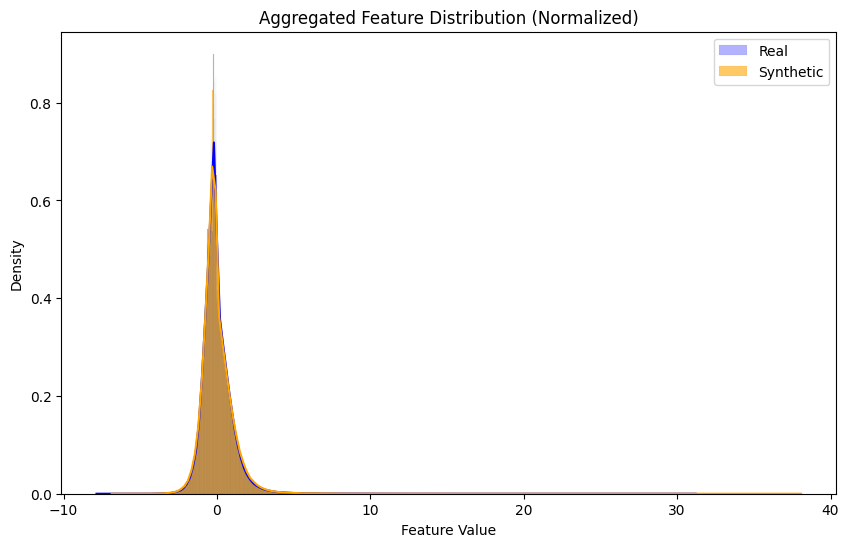

In [86]:
def plot_aggregated_feature_histograms(real_features, synthetic_features):
    """
    Plot histograms of the aggregated features from both real and synthetic datasets.

    Parameters:
    - real_features (np.ndarray): Feature array for the real dataset.
    - synthetic_features (np.ndarray): Feature array for the synthetic dataset.

    This function normalizes the features of both datasets (zero mean and unit variance),
    aggregates all features into a single flattened distribution, and visualizes their
    density using overlaid histograms. The plot provides insights into the overall
    similarity or differences between the distributions of the real and synthetic datasets.
    """
    # Step 1: Normalize each feature for both datasets to ensure comparability
    real_features_normalized = (real_features - np.mean(real_features, axis=0)) / np.std(real_features, axis=0)
    synthetic_features_normalized = (synthetic_features - np.mean(synthetic_features, axis=0)) / np.std(synthetic_features, axis=0)

    # Step 2: Flatten the normalized feature arrays into a single 1D array for each dataset
    real_features_flat = real_features_normalized.flatten()
    synthetic_features_flat = synthetic_features_normalized.flatten()

    # Step 3: Plot overlaid histograms of the aggregated features
    plt.figure(figsize=(10, 6))  # Set the figure size for the plot

    # Plot histogram for real features with density estimate (kde)
    sns.histplot(
        real_features_flat,
        label='Real',
        kde=True,
        color='blue',
        alpha=0.3,
        stat="density"
    )

    # Plot histogram for synthetic features with density estimate (kde)
    sns.histplot(
        synthetic_features_flat,
        label='Synthetic',
        kde=True,
        color='orange',
        alpha=0.6,
        stat="density"
    )

    # Step 4: Add plot titles, labels, and legend for better interpretation
    plt.title("Aggregated Feature Distribution (Normalized)")  # Title of the plot
    plt.xlabel("Feature Value")  # Label for the x-axis
    plt.ylabel("Density")  # Label for the y-axis
    plt.legend()  # Add a legend to indicate the datasets
    plt.show()  # Display the plot

# Example call to the function
plot_aggregated_feature_histograms(ddsm_features, medigan_features)


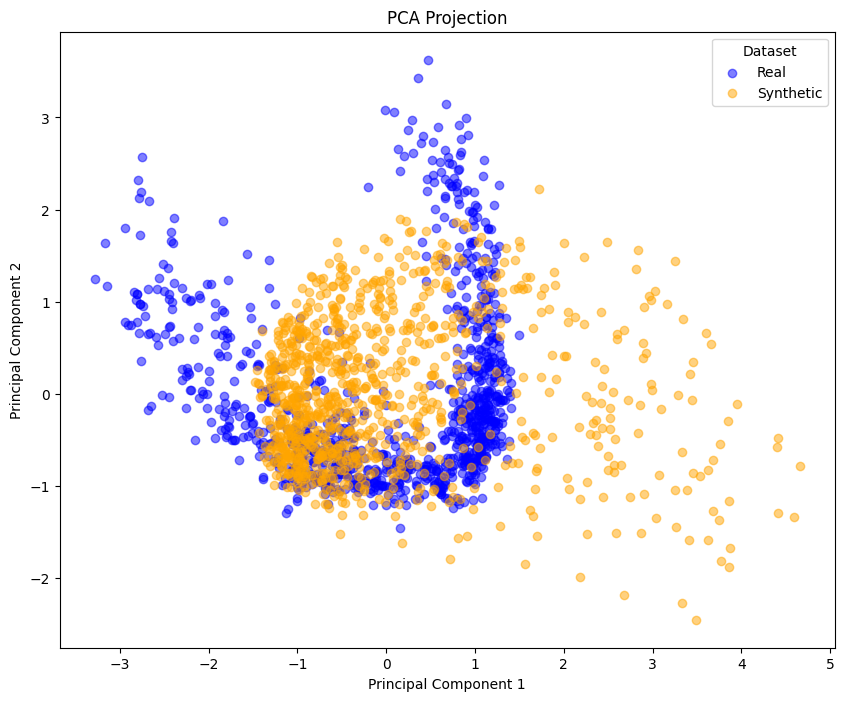

In [87]:
# Ensure `ddsm_features` and `huggingface_features` are numpy arrays
ddsm_features = np.array(ddsm_features)
medigan_features = np.array(medigan_features)

# Step 1: Remove rows with NaN values in either dataset
ddsm_features = ddsm_features[~np.isnan(ddsm_features).any(axis=1)]
medigan_features = medigan_features[~np.isnan(medigan_features).any(axis=1)]

# Step 2: Ensure both datasets have the same shape for fair comparison
min_length = min(len(ddsm_features), len(medigan_features))
ddsm_features = ddsm_features[:min_length]
medigan_features = medigan_features[:min_length]

def plot_pca_separately(real_features, synthetic_features):
    """
    Visualize the PCA projection of real and synthetic features separately.

    Parameters:
    - real_features (np.ndarray): Feature array for the real dataset.
    - synthetic_features (np.ndarray): Feature array for the synthetic dataset.

    This function applies PCA to reduce the feature space of each dataset to 2 dimensions
    and plots the results in a scatterplot for comparison. Each dataset is processed
    independently, which ensures the PCA projections highlight differences in the
    respective feature distributions.
    """
    # Step 1: Initialize PCA instances for each dataset
    pca_real = PCA(n_components=2)  # PCA for real features
    pca_synthetic = PCA(n_components=2)  # PCA for synthetic features

    # Step 2: Fit PCA to each dataset and transform the features
    real_pca = pca_real.fit_transform(real_features)  # PCA projection for real features
    synthetic_pca = pca_synthetic.fit_transform(synthetic_features)  # PCA projection for synthetic features

    # Step 3: Plot the PCA projections
    plt.figure(figsize=(10, 8))  # Set the figure size

    # Scatter plot for real features
    plt.scatter(
        real_pca[:, 0],
        real_pca[:, 1],
        color='blue',
        alpha=0.5,
        label='Real'
    )

    # Scatter plot for synthetic features
    plt.scatter(
        synthetic_pca[:, 0],
        synthetic_pca[:, 1],
        color='orange',
        alpha=0.5,
        label='Synthetic'
    )

    # Step 4: Add plot details for better interpretation
    plt.title('PCA Projection')  # Title of the plot
    plt.xlabel('Principal Component 1')  # Label for the x-axis
    plt.ylabel('Principal Component 2')  # Label for the y-axis
    plt.legend(title="Dataset")  # Add a legend with a title
    plt.show()  # Display the plot

# Call the function with your feature data
plot_pca_separately(ddsm_features, medigan_features)


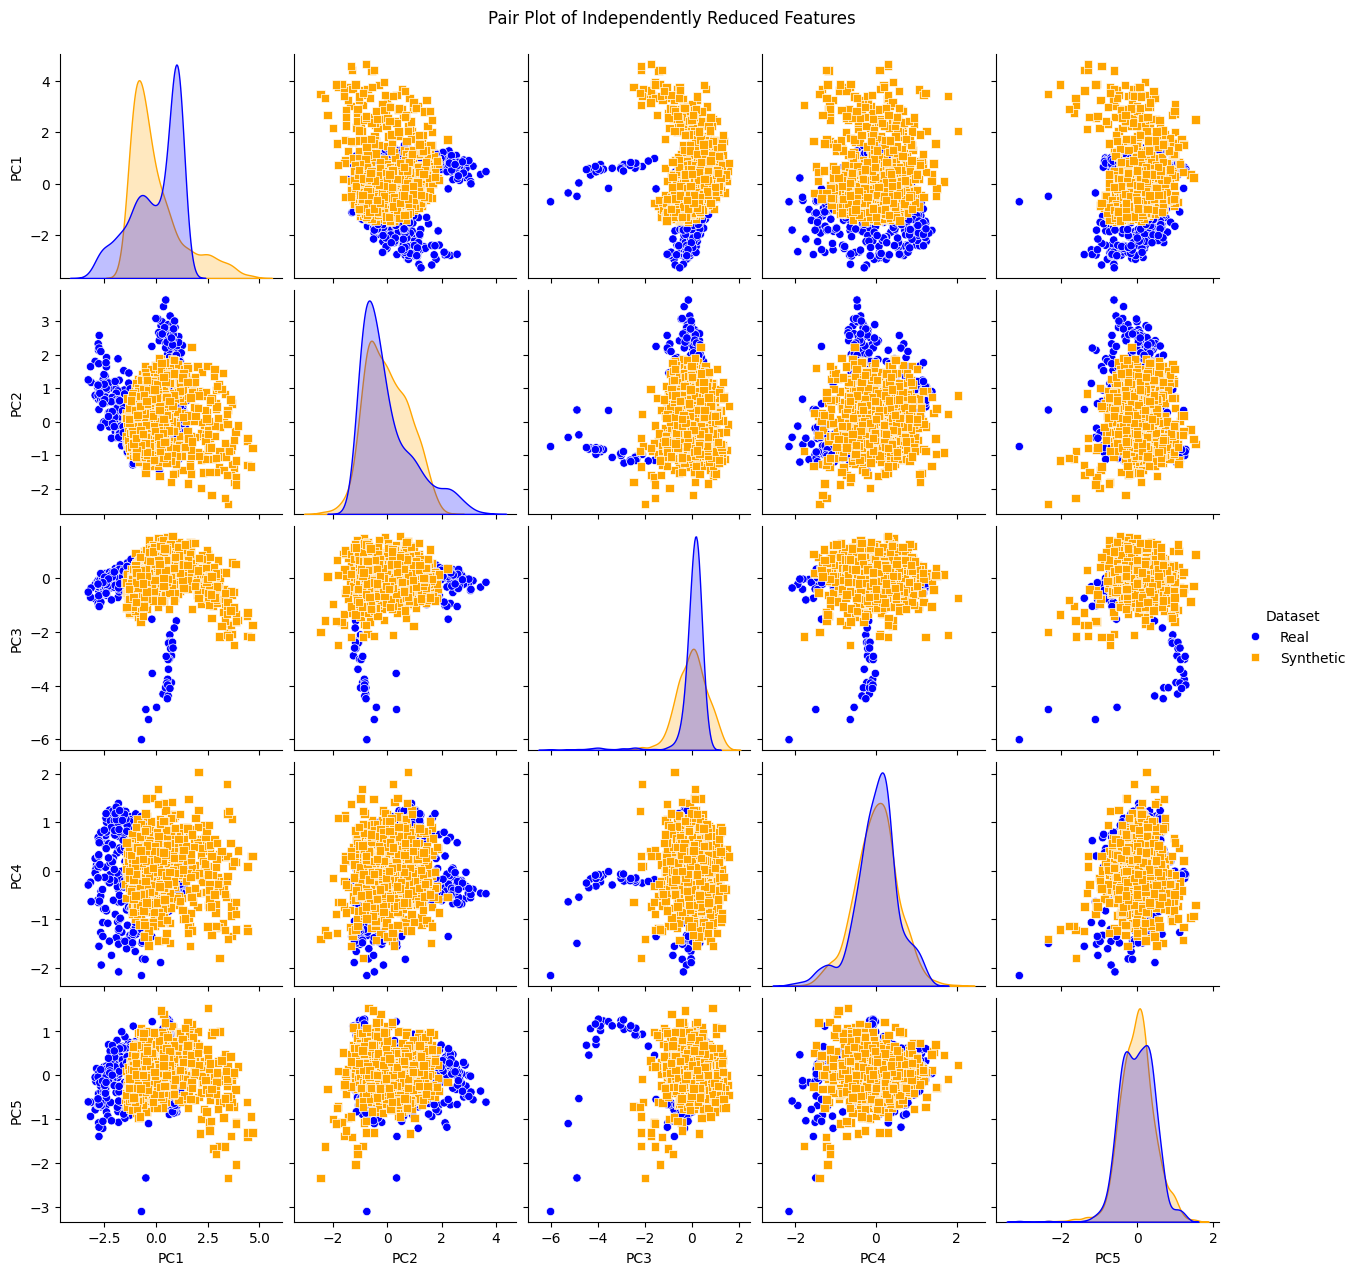

In [88]:
def plot_pairplot_independent(real_features, synthetic_features, components=5):
    """
    Generate a pair plot to visualize relationships between principal components
    of real and synthetic datasets after reducing dimensions independently.

    Parameters:
    - real_features (np.ndarray): Feature array for the real dataset.
    - synthetic_features (np.ndarray): Feature array for the synthetic dataset.
    - components (int): Number of principal components to retain during PCA.

    This function applies PCA independently to each dataset, retains the specified
    number of components, and visualizes the relationships between these components
    using a pair plot. The pair plot allows for a side-by-side comparison of the
    distributions and relationships in the real and synthetic datasets.
    """
    # Step 1: Apply PCA independently to both datasets
    pca_real = PCA(n_components=components)  # PCA for real features
    pca_synthetic = PCA(n_components=components)  # PCA for synthetic features

    # Fit PCA and transform the features
    real_transformed = pca_real.fit_transform(real_features)
    synthetic_transformed = pca_synthetic.fit_transform(synthetic_features)

    # Step 2: Create DataFrames for better visualization
    # Create DataFrame for real features
    df_real = pd.DataFrame(
        real_transformed,
        columns=[f'PC{i+1}' for i in range(components)]
    )
    df_real['Dataset'] = 'Real'  # Add a column to indicate the dataset

    # Create DataFrame for synthetic features
    df_synthetic = pd.DataFrame(
        synthetic_transformed,
        columns=[f'PC{i+1}' for i in range(components)]
    )
    df_synthetic['Dataset'] = 'Synthetic'  # Add a column to indicate the dataset

    # Combine the two DataFrames
    df_combined = pd.concat([df_real, df_synthetic], ignore_index=True)

    # Step 3: Generate a pair plot
    pair_plot = sns.pairplot(
        df_combined,
        hue='Dataset',
        palette={'Real': 'blue', 'Synthetic': 'orange'},
        markers=["o", "s"]
    )

    # Step 4: Add title and adjust layout
    pair_plot.fig.suptitle(
        'Pair Plot of Independently Reduced Features',
        y=1.02  # Adjust title position for better visualization
    )

    # Step 5: Display the plot
    plt.show()

# Example usage (assuming `ddsm_features` and `huggingface_features` are your datasets)
plot_pairplot_independent(ddsm_features, medigan_features, components=5)


In [89]:
warnings.filterwarnings('ignore')  # Suppress warnings, use with caution

def compute_kid(real_features, synthetic_features):
    """
    Compute Kernel Inception Distance (KID) using linear kernel embedding distance.

    Parameters:
    - real_features (np.ndarray): Features extracted from the real dataset.
    - synthetic_features (np.ndarray): Features extracted from the synthetic dataset.

    Returns:
    - float: KID value.
    """
    mean_real = np.mean(real_features, axis=0)
    mean_synthetic = np.mean(synthetic_features, axis=0)
    kid = np.sum((mean_real - mean_synthetic) ** 2)
    return kid

def compute_emd(real_features, synthetic_features):
    """
    Compute Earth Mover's Distance (EMD) between real and synthetic features.

    Parameters:
    - real_features (np.ndarray): Features from the real dataset.
    - synthetic_features (np.ndarray): Features from the synthetic dataset.

    Returns:
    - float: EMD value.
    """
    # Compute cost matrix based on Euclidean distance
    cost_matrix = cdist(real_features, synthetic_features, metric='euclidean')

    # Uniform distributions over samples
    a, b = np.ones((real_features.shape[0],)) / real_features.shape[0], \
           np.ones((synthetic_features.shape[0],)) / synthetic_features.shape[0]

    # Compute EMD using Optimal Transport
    emd_value = ot.emd2(a, b, cost_matrix)
    return emd_value

def compute_metrics(real_features, synthetic_features):
    """
    Compute multiple metrics to compare real and synthetic datasets.

    Parameters:
    - real_features (np.ndarray): Real dataset features.
    - synthetic_features (np.ndarray): Synthetic dataset features.

    Returns:
    - dict: Dictionary containing computed metrics.
    """
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(synthetic_features, axis=0), np.cov(synthetic_features, rowvar=False)

    epsilon = 1e-6  # Add small value to ensure numerical stability
    sigma1 += epsilon * np.eye(sigma1.shape[0])
    sigma2 += epsilon * np.eye(sigma2.shape[0])

    # Frechet Inception Distance (FID)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    covmean = covmean.real if np.iscomplexobj(covmean) else covmean
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    # Compute other metrics
    kid = compute_kid(real_features, synthetic_features)
    jsd = 0.5 * (entropy(mu1, mu2) + entropy(mu2, mu1))
    emd = compute_emd(real_features, synthetic_features)
    kld = entropy(mu1, mu2)
    ks_stat, ks_pvalue = ks_2samp(real_features.flatten(), synthetic_features.flatten())
    cvm_stat = cramervonmises_2samp(real_features.flatten(), synthetic_features.flatten()).statistic

    try:
        ad_stat = anderson_ksamp([real_features.flatten(), synthetic_features.flatten()]).statistic
    except Exception:
        ad_stat = np.nan

    bhattacharyya = np.nan  # Placeholder for future computation
    hellinger = np.sqrt(0.5 * np.sum((np.sqrt(mu1) - np.sqrt(mu2)) ** 2))
    cosine_sim = cosine_similarity(real_features, synthetic_features).mean()

    return {
        'FID': fid,
        'KID': kid,
        'JSD': jsd,
        'EMD': emd,
        'KLD': kld,
        'KS Statistic': ks_stat,
        'KS p-value': ks_pvalue,
        'Cramér-von Mises': cvm_stat,
        'Anderson-Darling': ad_stat,
        'Bhattacharyya': bhattacharyya,
        'Hellinger': hellinger,
        'Cosine Similarity': cosine_sim
    }

def evaluate_metrics_10_folds(real_features, synthetic_features, n_splits=10):
    """
    Evaluate metrics using 10-fold cross-validation.

    Parameters:
    - real_features (np.ndarray): Real dataset features.
    - synthetic_features (np.ndarray): Synthetic dataset features.
    - n_splits (int): Number of folds for cross-validation.

    Returns:
    - dict: Dictionary containing mean and standard deviation of metrics across folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_metrics = []

    for i, (train_index, test_index) in enumerate(kf.split(real_features)):
        real_fold = real_features[test_index]
        synthetic_fold = synthetic_features[np.random.choice(len(synthetic_features), len(real_fold), replace=False)]
        metrics = compute_metrics(real_fold, synthetic_fold)
        all_metrics.append(metrics)
        print(f"Fold {i+1}, Number of Samples: {len(test_index)}")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")

    # Aggregate metrics across folds
    aggregated_metrics = {key: [m[key] for m in all_metrics] for key in all_metrics[0].keys()}
    final_metrics = {
        f'{key} Mean': np.mean(aggregated_metrics[key]) for key in aggregated_metrics
    }
    final_metrics.update({
        f'{key} Std': np.std(aggregated_metrics[key]) for key in aggregated_metrics
    })

    return final_metrics

# Example usage (assuming features are loaded as ddsm_features and medigan_features)
cv_metrics = evaluate_metrics_10_folds(ddsm_features, medigan_features, n_splits=10)
print("\nCross-validated Metrics Summary:")
for key, value in cv_metrics.items():
    print(f"{key}: {value:.4f}")


Fold 1, Number of Samples: 98
  FID: 8.3522
  KID: 3.5504
  JSD: inf
  EMD: 2.9565
  KLD: inf
  KS Statistic: 0.0178
  KS p-value: 0.0000
  Cramér-von Mises: 14.3620
  Anderson-Darling: 109.3431
  Bhattacharyya: nan
  Hellinger: 1.6972
  Cosine Similarity: 0.9432
Fold 2, Number of Samples: 98
  FID: 8.7260
  KID: 3.7660
  JSD: inf
  EMD: 2.9935
  KLD: inf
  KS Statistic: 0.0136
  KS p-value: 0.0000
  Cramér-von Mises: 7.3836
  Anderson-Darling: 60.9284
  Bhattacharyya: nan
  Hellinger: 1.7331
  Cosine Similarity: 0.9422
Fold 3, Number of Samples: 98
  FID: 9.4997
  KID: 4.0437
  JSD: inf
  EMD: 3.1172
  KLD: inf
  KS Statistic: 0.0246
  KS p-value: 0.0000
  Cramér-von Mises: 26.7888
  Anderson-Darling: 189.5031
  Bhattacharyya: nan
  Hellinger: 1.8325
  Cosine Similarity: 0.9389
Fold 4, Number of Samples: 98
  FID: 8.2319
  KID: 3.5946
  JSD: inf
  EMD: 2.9715
  KLD: inf
  KS Statistic: 0.0165
  KS p-value: 0.0000
  Cramér-von Mises: 12.8171
  Anderson-Darling: 96.9063
  Bhattacharyya:

In [90]:
# Computing metrics directly for overall comparison
metrics = compute_metrics(ddsm_features, medigan_features)
print("Metrics between real and synthetic features:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Metrics between real and synthetic features:
FID: 7.8116
KID: 3.7053
JSD: inf
EMD: 2.9561
KLD: 0.0468
KS Statistic: 0.0177
KS p-value: 0.0000
Cramér-von Mises: 148.5695
Anderson-Darling: 1128.5844
Bhattacharyya: nan
Hellinger: 1.7051
Cosine Similarity: 0.9417


# -----------------------------------------------
# Metrics Computation: Explanation of Each Metric
# -----------------------------------------------

"""
This section of the code focuses on calculating various metrics to compare the similarity between
real and synthetic datasets. Below is an explanation of the metrics implemented:

1. **Earth Mover's Distance (EMD)**:
    - Measures the minimum cost to transform one distribution into another using a distance metric (e.g., Euclidean).
    - Suitable for comparing two probability distributions.

2. **Hellinger Distance**:
    - Measures the similarity between two probability distributions.
    - The distance lies in the range [0, 1], where 0 indicates identical distributions and 1 indicates maximum dissimilarity.

3. **Jensen-Shannon Distance (JSD)**:
    - A symmetric version of Kullback-Leibler divergence.
    - Indicates the divergence between two probability distributions. The distance lies in the range [0, 1].

4. **Kolmogorov-Smirnov Test (KS Test)**:
    - A statistical test that quantifies the difference between the empirical cumulative distribution functions of two datasets.
    - Reports both the test statistic and the p-value.

5. **Anderson-Darling Test**:
    - Tests if two datasets come from the same distribution.
    - More sensitive to differences in the tails of distributions compared to the KS test.

6. **Cosine Similarity**:
    - Measures the cosine of the angle between two feature vectors.
    - A value of 1 indicates identical directions, and values closer to 0 indicate orthogonality.

7. **Kullback-Leibler Divergence (KLD)**:
    - Measures how one probability distribution diverges from another.
    - Asymmetric and prone to infinite values if one distribution contains zeros.

8. **Cramér-von Mises Test**:
    - Assesses the goodness-of-fit between two distributions.
    - Reports a test statistic, with smaller values indicating better alignment.

9. **Bhattacharyya Coefficient**:
    - Measures the amount of overlap between two statistical samples.
    - Values closer to 1 indicate greater overlap.

10. **Frechet Inception Distance (FID)**:
    - Measures the similarity between two distributions in terms of feature statistics (mean and covariance).
    - Commonly used for evaluating the quality of generative models.

11. **Kernel Inception Distance (KID)**:
    - Similar to FID but computes differences in feature embeddings using a kernel function.

12. **Cohort-Wise Analysis**:
    - The metrics are evaluated using a 10-fold cross-validation approach, ensuring robustness and reliability.

Overall, these metrics provide a comprehensive evaluation of the similarity between real and synthetic data in terms of statistical alignment and feature space overlap.
"""


In [91]:
from scipy.stats import kstest  # Ensure Kolmogorov-Smirnov test is imported

# Example Feature Loading (replace with actual loading logic if needed)
# ddsm_features = np.load('path_to_ddsm_features.npy')
# huggingface_features = np.load('path_to_huggingface_features.npy')

# Normalize histograms if these are probability distributions
# ddsm_features /= ddsm_features.sum(axis=1, keepdims=True)
# huggingface_features /= huggingface_features.sum(axis=1, keepdims=True)

# -------------------------
# Compute Earth Mover's Distance (EMD)
# -------------------------
distance_matrix = cdist(ddsm_features, medigan_features, 'euclidean')
weights_ddsm = np.ones(ddsm_features.shape[0]) / ddsm_features.shape[0]
weights_huggingface = np.ones(medigan_features.shape[0]) / medigan_features.shape[0]
emd_value = ot.emd2(weights_ddsm, weights_huggingface, distance_matrix)
print("EMD Value:", emd_value)

# -------------------------
# Compute Hellinger Distance
# -------------------------
def hellinger_dot(p, q):
    """
    Compute the Hellinger distance between two distributions.

    Parameters:
    - p (np.ndarray): First distribution.
    - q (np.ndarray): Second distribution.

    Returns:
    - float: Hellinger distance.
    """
    # Ensure non-negative values
    p = np.abs(p)
    q = np.abs(q)
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2) / 2)

# Fix for potential negative values in the input
ddsm_mean = np.abs(ddsm_features.mean(axis=0))
huggingface_mean = np.abs(medigan_features.mean(axis=0))

hellinger_distance = hellinger_dot(ddsm_mean, huggingface_mean)
print("Hellinger Distance:", hellinger_distance)

# -------------------------
# Compute Jensen-Shannon Distance
# -------------------------
js_distance = jensenshannon(ddsm_features.mean(axis=0), medigan_features.mean(axis=0))
print("Jensen-Shannon Distance:", js_distance)

# -------------------------
# Statistical Tests
# -------------------------
# Kolmogorov-Smirnov Test
ks_statistic, ks_pvalue = kstest(ddsm_features.flatten(), medigan_features.flatten())
print("KS Statistic:", ks_statistic, "KS p-value:", ks_pvalue)

# -------------------------
# Compute Cosine Similarity
# -------------------------
cos_similarity = cosine_similarity(ddsm_features, medigan_features).mean()
print("Average Cosine Similarity:", cos_similarity)


EMD Value: 2.9560816537568844
Hellinger Distance: 1.7051299241827016
Jensen-Shannon Distance: 0.1065499215453698
KS Statistic: 0.01767277644230769 KS p-value: 2.675570733467126e-271
Average Cosine Similarity: 0.9417460769035445


In [92]:
def calculate_fid(mu1, sigma1, mu2, sigma2):
    """Calculate the FID score between two distributions."""
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Calculate mean and covariance of the features
mu1, sigma1 = np.mean(ddsm_features, axis=0), np.cov(ddsm_features, rowvar=False)
mu2, sigma2 = np.mean(medigan_features, axis=0), np.cov(medigan_features, rowvar=False)

# Calculate FID
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)
print("FID Score:", fid_score)


FID Score: 7.814990499720978


# -----------------------------------------------
# Recomputing Metrics After Accounting for Dataset Size Differences
# -----------------------------------------------

"""
This part of the code is focused on recomputing similarity metrics between real and synthetic datasets
after ensuring their feature distributions account for differences in dataset sizes. This adjustment
helps avoid biases in metrics that might arise due to imbalances in the number of samples.

Description of Key Steps:

1. **Resizing and Preprocessing Images**:
   - Each image is resized to a standard size of 256x256 pixels.
   - Ensures consistent input dimensions for feature extraction.

2. **Statistical Feature Extraction**:
   - Features such as mean, standard deviation, skewness, kurtosis, and median values are computed.
   - These provide a basic statistical representation of the pixel intensity distribution.

3. **Edge Detection Features**:
   - Edge density and average edge intensity are computed using the Canny edge detection algorithm.
   - These features capture the structural patterns in the images.

4. **Brightness and Contrast**:
   - Brightness is calculated as the mean pixel intensity.
   - Contrast is the difference between the maximum and minimum pixel intensities.

5. **Fourier Transform Features**:
   - The image is transformed to the frequency domain using the Fourier transform.
   - Low-frequency and high-frequency energies are calculated to capture texture information.

6. **Topological Features**:
   - Persistent homology is applied to compute Betti numbers (Betti 0 and Betti 1).
   - These features provide insights into the topological properties of the image.

7. **Gabor Filter Features**:
   - A Gabor filter is applied to extract texture features such as Gabor mean and Gabor standard deviation.

8. **Entropy**:
   - Local entropy is computed using a disk filter, capturing the randomness in pixel intensity.

9. **Error Handling**:
   - If an image fails to process (e.g., due to invalid format or dimensionality issues), the function returns NaNs to ensure the pipeline remains robust.

This recomputation aligns the feature spaces of the datasets, ensuring a fair comparison in subsequent metric calculations.
"""


In [93]:
# Example Code: Feature Extraction Function
def compute_non_deep_features(image_array):
    """
    Extract non-deep learning features from an image.

    Parameters:
    - image_array (np.ndarray): Input grayscale image.

    Returns:
    - list: A list of extracted features, or NaNs if an error occurs.
    """
    try:
        # Resize and preprocess image
        image = Image.fromarray(image_array).resize((256, 256))
        image_array = np.array(image)

        # Ensure the image is 2D
        if image_array.ndim != 2:
            raise ValueError("Input image must be grayscale (2D array).")

        # Statistical features
        mean_val = np.mean(image_array)
        std_val = np.std(image_array)
        skewness = stats.skew(image_array.flatten())
        kurtosis = stats.kurtosis(image_array.flatten())
        median_val = np.median(image_array)

        # Edge detection features
        edges = feature.canny(image_array)
        edge_density = np.sum(edges) / edges.size
        avg_edge_intensity = np.mean(image_array[edges]) if edges.any() else 0

        # Contrast and brightness
        contrast = image_array.max() - image_array.min()
        brightness = np.mean(image_array)

        # Fourier transform features
        f_transform = np.fft.fft2(image_array)
        f_transform_shift = np.fft.fftshift(f_transform)
        magnitude_spectrum = np.abs(f_transform_shift)
        low_freq_energy = np.sum(magnitude_spectrum[:10, :10])
        high_freq_energy = np.sum(magnitude_spectrum[-10:, -10:])

        # Topological features using Persistent Homology
        cubical_complex = CubicalComplex(dimensions=image_array.shape, top_dimensional_cells=image_array.flatten())
        persistence = cubical_complex.persistence()
        betti_0 = sum(1 for _, dim in persistence if dim == 0)
        betti_1 = sum(1 for _, dim in persistence if dim == 1)

        # Gabor filter features
        gabor_filtered, _ = gabor(image_array, frequency=0.6)
        gabor_mean = np.mean(gabor_filtered)
        gabor_std = np.std(gabor_filtered)

        # Entropy
        hist_entropy = entropy(image_array, disk(5)).mean() if image_array.any() else 0

        # Combine features into a list
        features = [
            mean_val, std_val, skewness, kurtosis, median_val,
            edge_density, avg_edge_intensity, contrast, brightness,
            low_freq_energy, high_freq_energy, betti_0, betti_1,
            gabor_mean, gabor_std, hist_entropy
        ]

        return features
    except Exception as e:
        print(f"Error processing image: {e}")
        return [np.nan] * 16  # Return NaNs if there's an error

In [95]:
from sklearn.utils import resample  # Import resample for bootstrapping
warnings.filterwarnings('ignore')  # Suppress warnings, use with caution
# ------------------------------------------------------
# Description of the Workflow
# ------------------------------------------------------

"""
This script handles feature cleaning, metric computation, bootstrapping for confidence intervals,
and cross-validation for real and synthetic datasets. Here's a breakdown of its components:

1. **Feature Cleaning**:
   - Removes invalid values (NaNs and Infs) in the feature arrays.
   - NaNs are replaced with the column mean, while Infs are replaced with the column maximum.
   - This ensures the feature arrays are suitable for downstream computations.

2. **Metric Computation**:
   - Calculates key similarity metrics between the real and synthetic feature sets:
       - **FID (Fréchet Inception Distance)**: Quantifies the similarity between the distributions of features.
       - **KID (Kernel Inception Distance)**: Measures the squared mean difference between feature embeddings.
       - **EMD (Earth Mover's Distance)**: Evaluates the minimum effort needed to transform one distribution into another.
       - **Cosine Similarity**: Captures the angular similarity between feature vectors.

3. **Bootstrapping for Confidence Intervals**:
   - Uses bootstrapping to estimate confidence intervals for the computed metrics.
   - Repeatedly samples (with replacement) from the feature arrays to compute metrics.
   - Reports the mean and 95% confidence intervals for each metric.

4. **Cross-Validation with Weighting**:
   - Divides the real feature set into folds for cross-validation.
   - Matches the size of synthetic samples to the real sample in each fold using random sampling.
   - Aggregates metrics across folds and reports the mean and standard deviation.

5. **Main Workflow**:
   - Cleans the real and synthetic feature datasets to ensure valid inputs.
   - Computes bootstrapped metrics and cross-validated metrics with weighting.
   - Outputs the metrics and their corresponding confidence intervals and standard deviations.
"""

# ------------------------------------------------------
# Code Implementation
# ------------------------------------------------------

warnings.filterwarnings('ignore')  # Suppress warnings, use with caution

# -----------------------
# Feature Cleaning
# -----------------------
def clean_features(features):
    """Clean feature array by replacing NaN and Inf values."""
    if np.isnan(features).any() or np.isinf(features).any():
        print("Cleaning feature array: replacing NaNs and Infs.")
        # Replace NaNs with column mean
        nan_mask = np.isnan(features)
        features[nan_mask] = np.nanmean(features, axis=0)[np.where(nan_mask)[1]]

        # Replace Infs with column max
        inf_mask = np.isinf(features)
        features[inf_mask] = np.nanmax(features, axis=0)[np.where(inf_mask)[1]]
    return features

# -----------------------
# Metric Computation
# -----------------------
def compute_metrics(real_features, synthetic_features):
    """
    Compute similarity metrics between real and synthetic features.
    Includes FID, KID, EMD, and Cosine Similarity.
    """
    # Compute means and covariance matrices
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(synthetic_features, axis=0), np.cov(synthetic_features, rowvar=False)

    # Add small epsilon to prevent numerical instability
    epsilon = 1e-6
    sigma1 += epsilon * np.eye(sigma1.shape[0])
    sigma2 += epsilon * np.eye(sigma2.shape[0])

    # Compute FID
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    covmean = covmean.real if np.iscomplexobj(covmean) else covmean
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    # Compute other metrics
    kid = np.sum((mu1 - mu2) ** 2)
    emd = ot.emd2(
        np.ones(len(real_features)) / len(real_features),
        np.ones(len(synthetic_features)) / len(synthetic_features),
        cdist(real_features, synthetic_features)
    )
    cosine_sim = cosine_similarity(real_features, synthetic_features).mean()

    return {
        'FID': fid,
        'KID': kid,
        'EMD': emd,
        'Cosine Similarity': cosine_sim
    }

# -----------------------
# Bootstrapping for Confidence Intervals
# -----------------------
def bootstrap_metrics(real_features, synthetic_features, n_iterations=1000, sample_size=None):
    """
    Estimate confidence intervals for metrics using bootstrapping.
    Repeatedly samples from the datasets and computes metrics.
    """
    metrics_list = []
    sample_size = sample_size or len(real_features)  # Default to real feature size
    for _ in tqdm(range(n_iterations), desc="Bootstrapping Metrics"):
        # Sample with replacement
        real_sample = resample(real_features, n_samples=sample_size, random_state=np.random.randint(0, 10000))
        synthetic_sample = resample(synthetic_features, n_samples=sample_size, random_state=np.random.randint(0, 10000))

        metrics = compute_metrics(real_sample, synthetic_sample)
        metrics_list.append(metrics)

    # Aggregate metrics and compute confidence intervals
    aggregated_metrics = {key: [m[key] for m in metrics_list] for key in metrics_list[0].keys()}
    final_metrics = {
        f'{key} Mean': np.mean(values) for key, values in aggregated_metrics.items()
    }
    final_metrics.update({
        f'{key} 95% CI': (np.percentile(values, 2.5), np.percentile(values, 97.5)) for key, values in aggregated_metrics.items()
    })

    return final_metrics

# -----------------------
# Cross-Validation with Weighting
# -----------------------
def evaluate_metrics_with_weighting(real_features, synthetic_features, n_splits=10):
    """
    Perform cross-validation with size-matched weighting for metrics.
    Splits the real dataset into folds and matches synthetic sample sizes.
    """
    real_features = clean_features(real_features)
    synthetic_features = clean_features(synthetic_features)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_metrics = []

    for i, (train_index, test_index) in enumerate(kf.split(real_features)):
        real_fold = real_features[test_index]

        # Match synthetic samples to the real fold size
        synthetic_sample = synthetic_features[np.random.choice(len(synthetic_features), len(real_fold), replace=False)]
        metrics = compute_metrics(real_fold, synthetic_sample)
        all_metrics.append(metrics)
        print(f"Fold {i+1}:")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")

    # Aggregate metrics
    aggregated_metrics = {key: [m[key] for m in all_metrics] for key in all_metrics[0].keys()}
    final_metrics = {
        f'{key} Mean': np.mean(aggregated_metrics[key]) for key in aggregated_metrics
    }
    final_metrics.update({
        f'{key} Std': np.std(aggregated_metrics[key]) for key in aggregated_metrics
    })

    return final_metrics

# -----------------------
# Main Workflow
# -----------------------
# Clean the feature datasets
ddsm_features = clean_features(ddsm_features)
huggingface_features = clean_features(medigan_features)

# Compute metrics with bootstrapping
print("\nBootstrapped Metrics:")
boot_metrics = bootstrap_metrics(ddsm_features, huggingface_features, n_iterations=1000, sample_size=len(ddsm_features))
for key, value in boot_metrics.items():
    print(f"{key}: {value}")

# Compute cross-validated metrics
print("\nCross-validated Metrics Summary (with Weighting):")
cv_metrics = evaluate_metrics_with_weighting(ddsm_features, huggingface_features, n_splits=10)
for key, value in cv_metrics.items():
    print(f"{key}: {value:.4f}")


Cleaning feature array: replacing NaNs and Infs.
Cleaning feature array: replacing NaNs and Infs.

Bootstrapped Metrics:


Bootstrapping Metrics:   0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: array must not contain infs or NaNs